In [189]:
import pandas as pd
import ultraplot as uplt
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.stats.multitest import fdrcorrection

In [19]:
year = 2021

In [22]:
# Load all of the precipitation data and merge into one dataframe
prcp_df = pd.read_csv(f'./Data/TimeImpacts/prcp_grid_1_{year}.csv')
for i in range(2, 53):
    temp_df = pd.read_csv(f'./Data/TimeImpacts/prcp_grid_{i}_{year}.csv')
    prcp_df = prcp_df.merge(temp_df, how='inner', on='system:index')

In [23]:
# Load all of the precipitation data and merge into one dataframe
tmax_df = pd.read_csv(f'./Data/TimeImpacts/tmax_grid_1_{year}.csv')
for i in range(2, 53):
    temp_df = pd.read_csv(f'./Data/TimeImpacts/tmax_grid_{i}_{year}.csv')
    tmax_df = tmax_df.merge(temp_df, how='inner', on='system:index')

In [24]:
full_df = pd.read_csv(f'./Data/TimeImpacts/forest_grid_{year}.csv')
full_df = full_df.merge(prcp_df, how='inner', left_on='id', right_on='system:index')
full_df = full_df.merge(tmax_df, how='inner', on='system:index')
full_df = full_df.drop('id', axis=1)
full_df['defol_forest_2'] = full_df['defoliation_2']/full_df['forest']
full_df['defol_forest_mask_2'] = full_df['defoliation_2']/full_df['qa_mask_2']
full_df['defol_forest_3'] = full_df['defoliation_3']/full_df['forest']
full_df['defol_forest_mask_3'] = full_df['defoliation_3']/full_df['qa_mask_3']
full_df.to_csv(f'./Data/TimeImpacts/time_lags_{year}.csv')

# Lag Analysis

In [142]:
prcp_anom_cols = [f'prcp_anom_{i}' for i in range(1, 53)]
tmax_anom_cols = [f'tmax_anom_{i}' for i in range(1, 53)]
prcp_mean_cols = [f'prcp_mean_{i}' for i in range(1, 53)]
tmax_mean_cols = [f'tmax_mean_{i}' for i in range(1, 53)]

In [27]:
df_2021 = pd.read_csv('./Data/TimeImpacts/time_lags_2021.csv')

df_2023 = pd.read_csv('./Data/TimeImpacts/time_lags_2023.csv')

full_df = pd.concat([df_2021, df_2023], axis=0)

In [43]:
def make_lag_fig(df, prcp_cols, tmax_cols, metric, title):
    fig, axes = uplt.subplots(ncols=2, suptitle=title)
        
    corrs = []
    for prcp_anom_col in prcp_cols:
        corrs.append(df[prcp_anom_col].corr(df[metric]))
    corrs = np.array(corrs)
    
    i = np.argmax(np.abs(corrs))+1
    
    axes[0].axvline(i, color='red')
    axes[0].axhline(0, color='gray', linestyle='dashed')
    axes[0].plot(np.arange(1, corrs.shape[0]+1), corrs, color='black')
    axes[0].format(title='Precipitation Anomaly', xlabel='Weeks')
    
    corrs = []
    for tmax_anom_col in tmax_cols:
        corrs.append(df[tmax_anom_col].corr(df[metric]))
    corrs = np.array(corrs)
    
    i = np.argmax(np.abs(corrs))+1
    
    axes[1].axvline(i, color='red')
    axes[1].axhline(0, color='gray', linestyle='dashed')
    axes[1].plot(np.arange(1, corrs.shape[0]+1), corrs, color='black')
    axes[1].format(title='Max. Temperature Anomaly', xlabel='Weeks')

## Regularization choice
Here we test what the impacts are of the choice of regularization using
- Total forest (2+ observations)
- Total forest (3+ observations)
- Unmasked forest (2+ observations)
- Unmasked forest (3+ observations)
Requiring 3+ observations appears to increase correlation, while regularizing based on the amount of unmasked forest decreases correlation.
For the rest of this analysis, I will use Total forest (3+ observations).

In [44]:
def test_metrics_on_lag(df):
    cutoff = 10_000_000
    # Filter out cells with insufficient forest area, and adjust defoliated area by forested area.
    df = df[df['forest'] > cutoff].copy()
    
    for metric in ['defol_forest_2', 'defol_forest_mask_2', 'defol_forest_3', 'defol_forest_mask_3']:
        make_lag_fig(df, prcp_anom_cols, tmax_anom_cols, metric, metric)

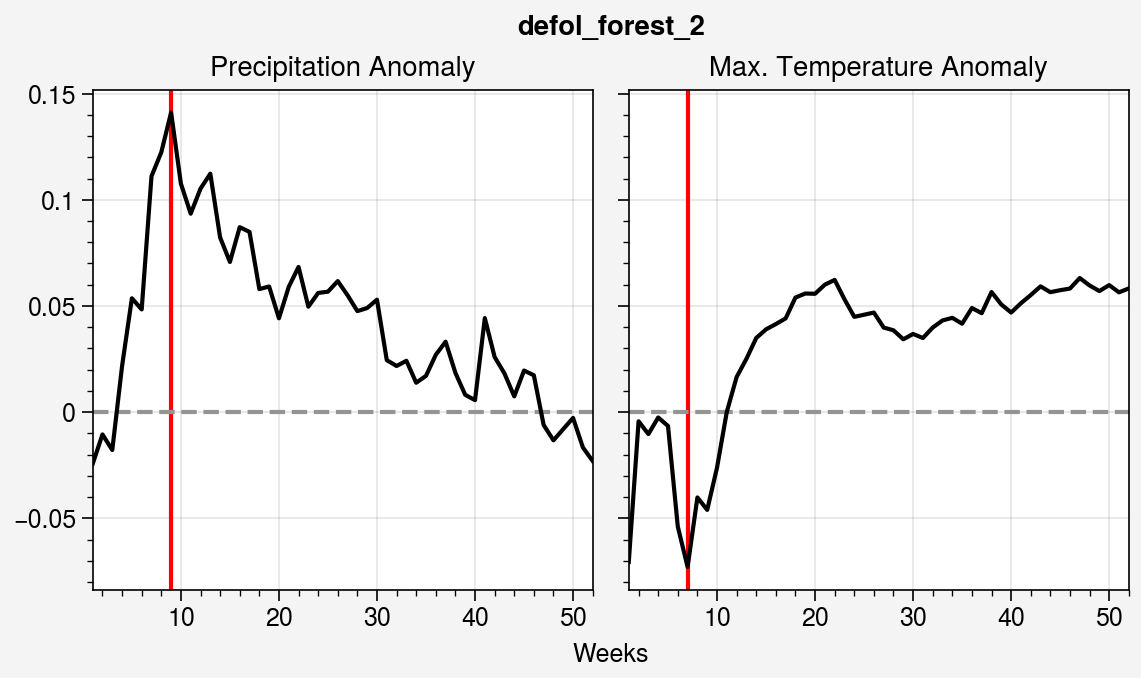

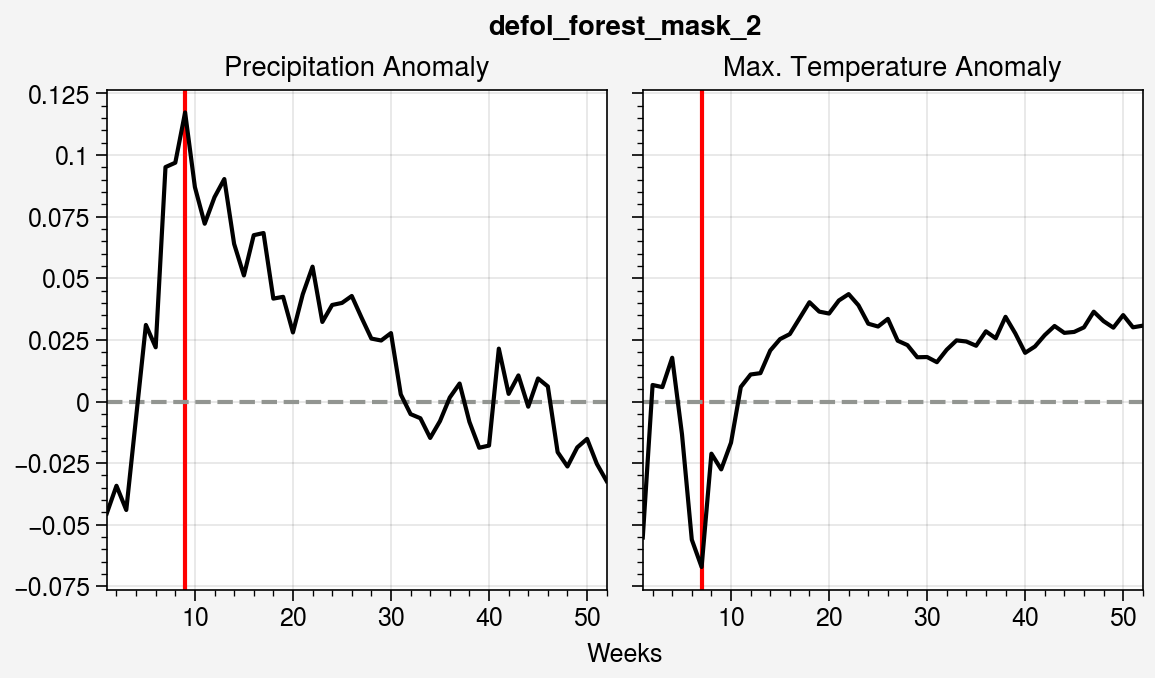

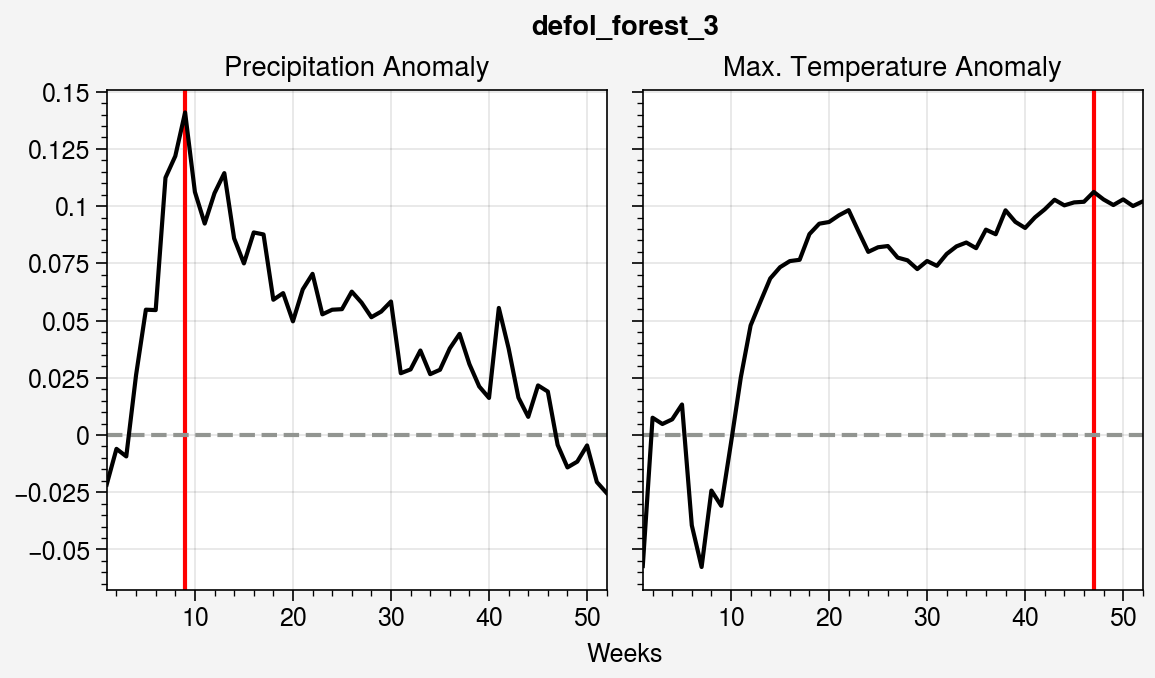

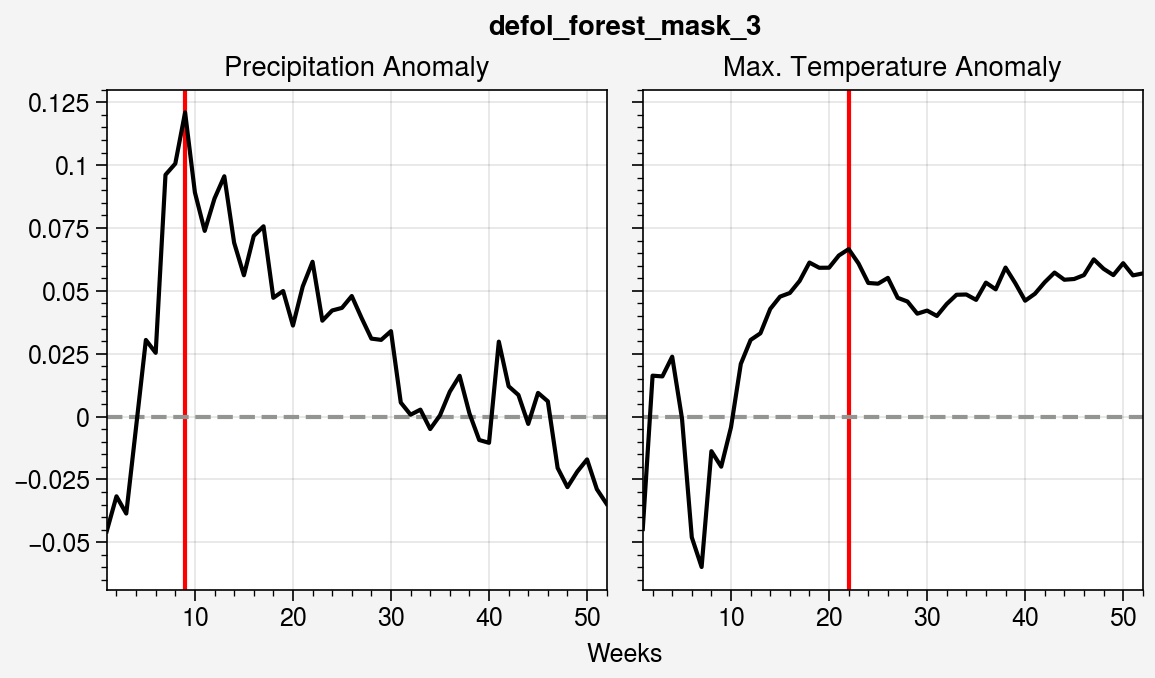

In [40]:
test_metrics_on_lag(df_2021)

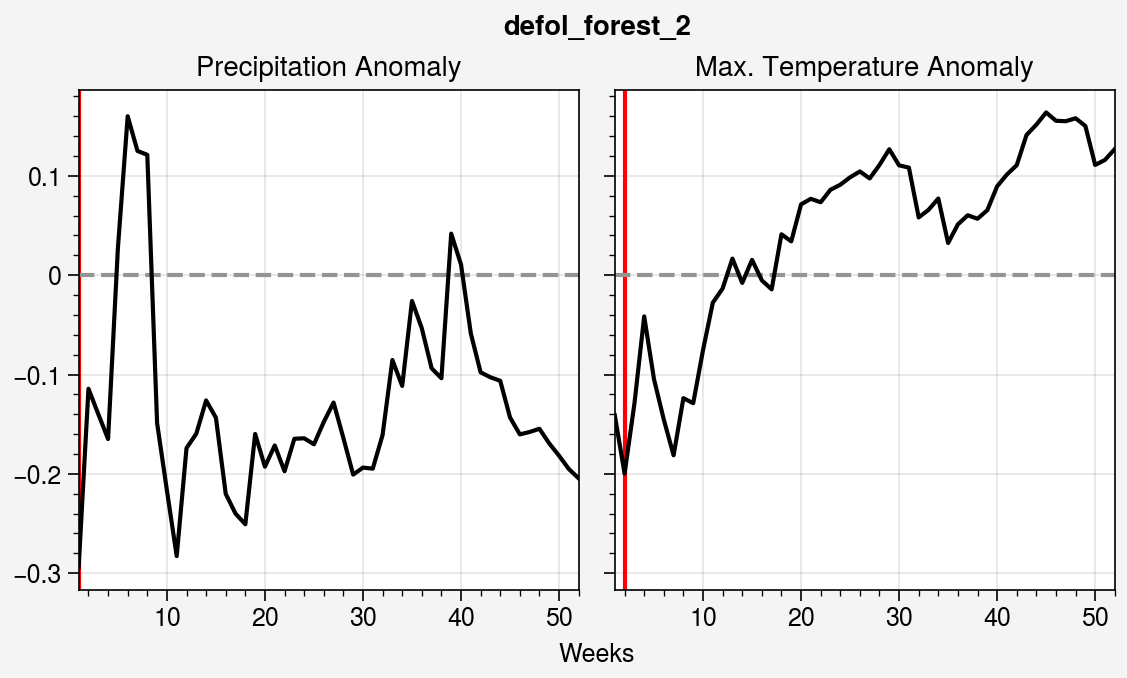

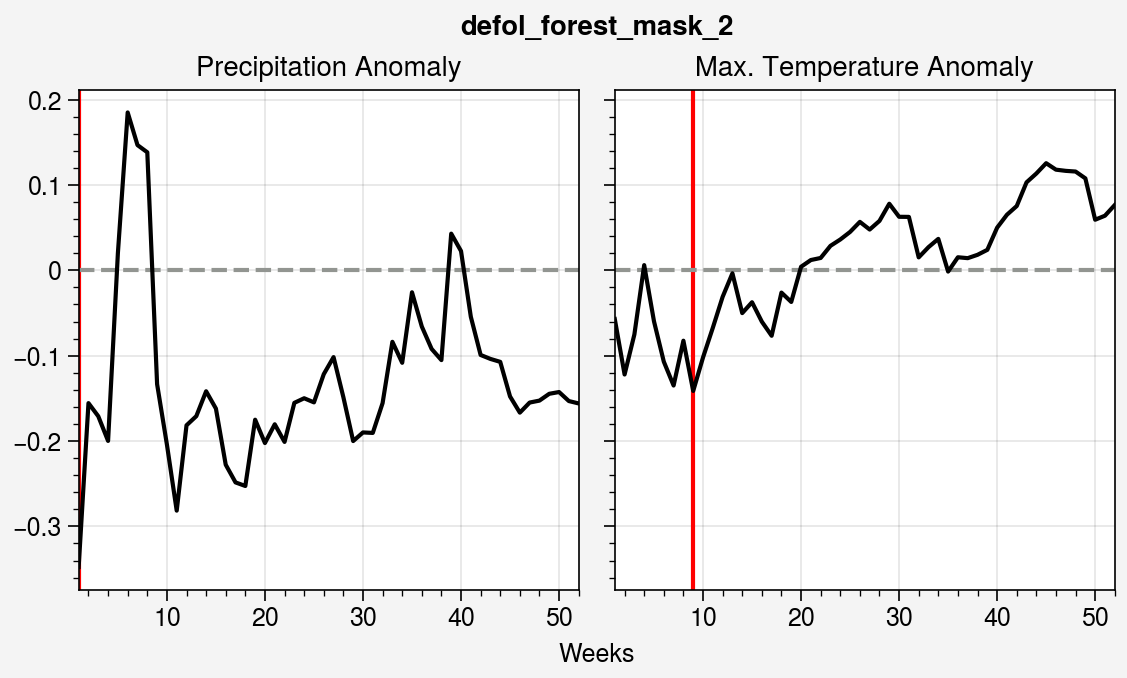

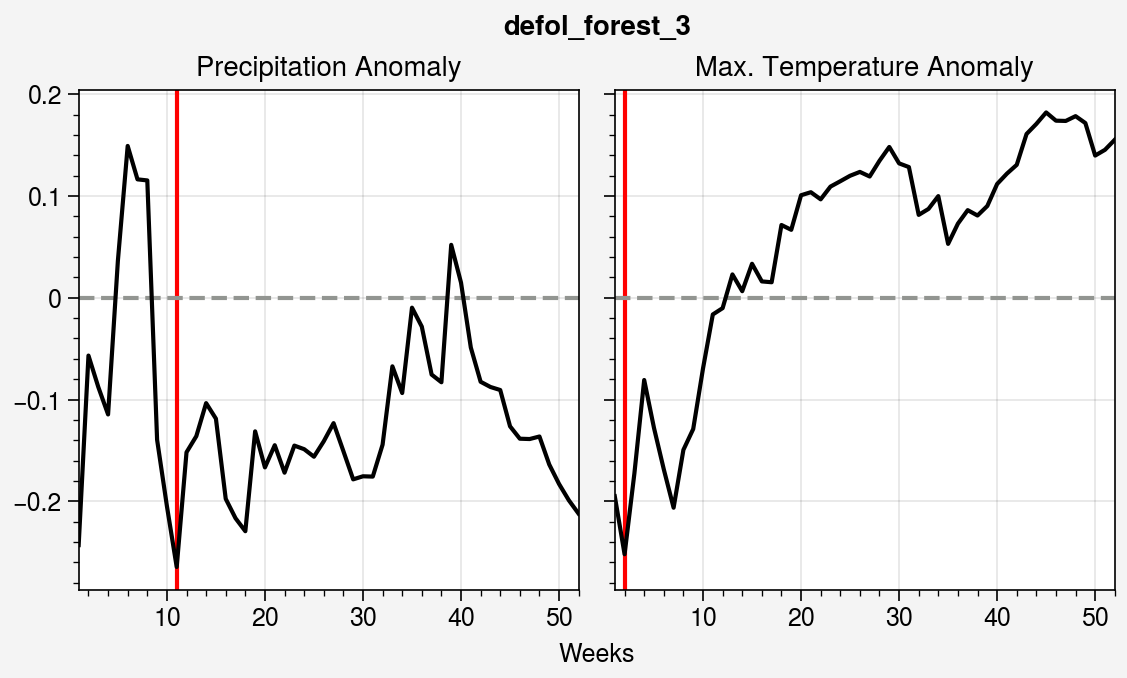

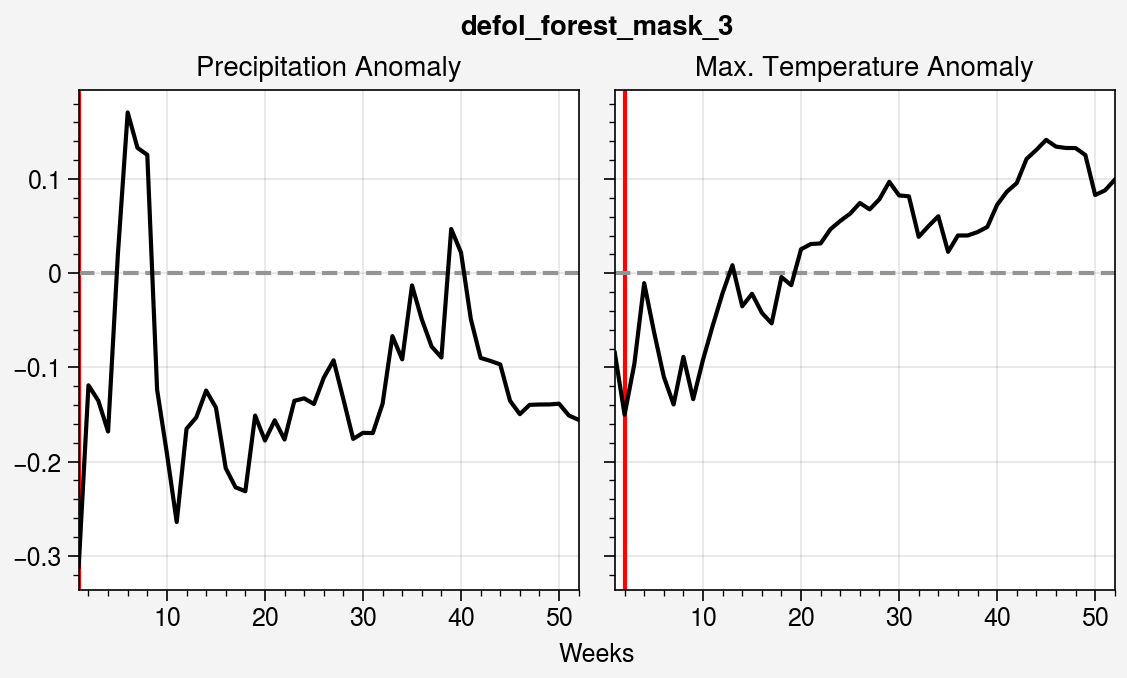

In [41]:
test_metrics_on_lag(df_2023)

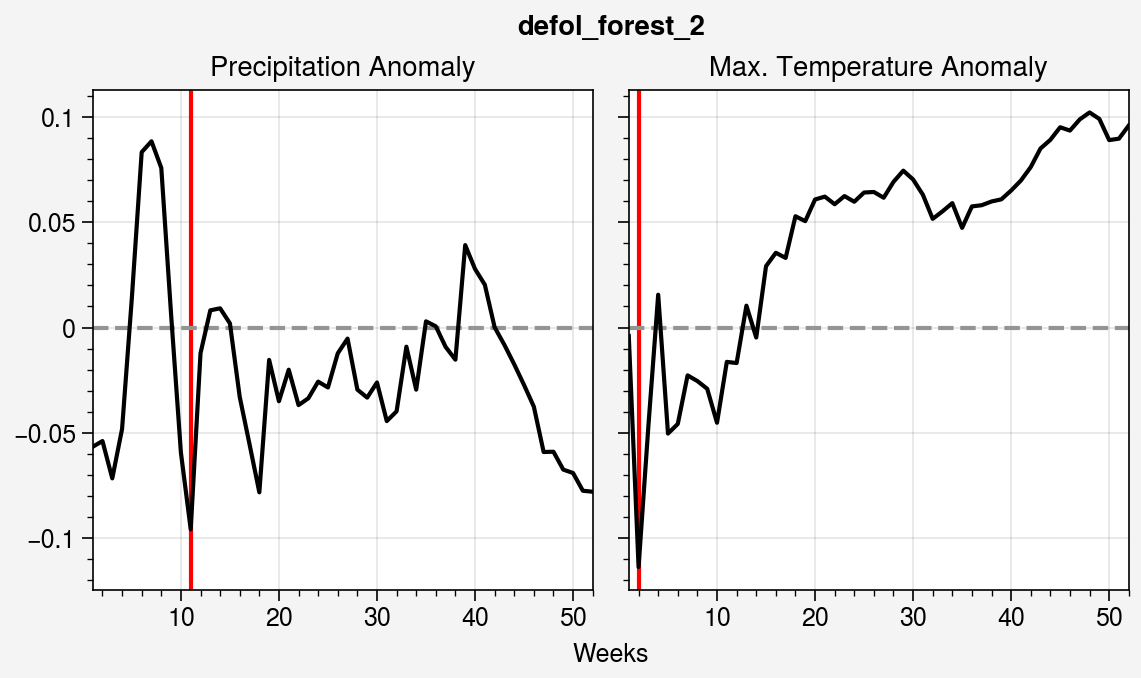

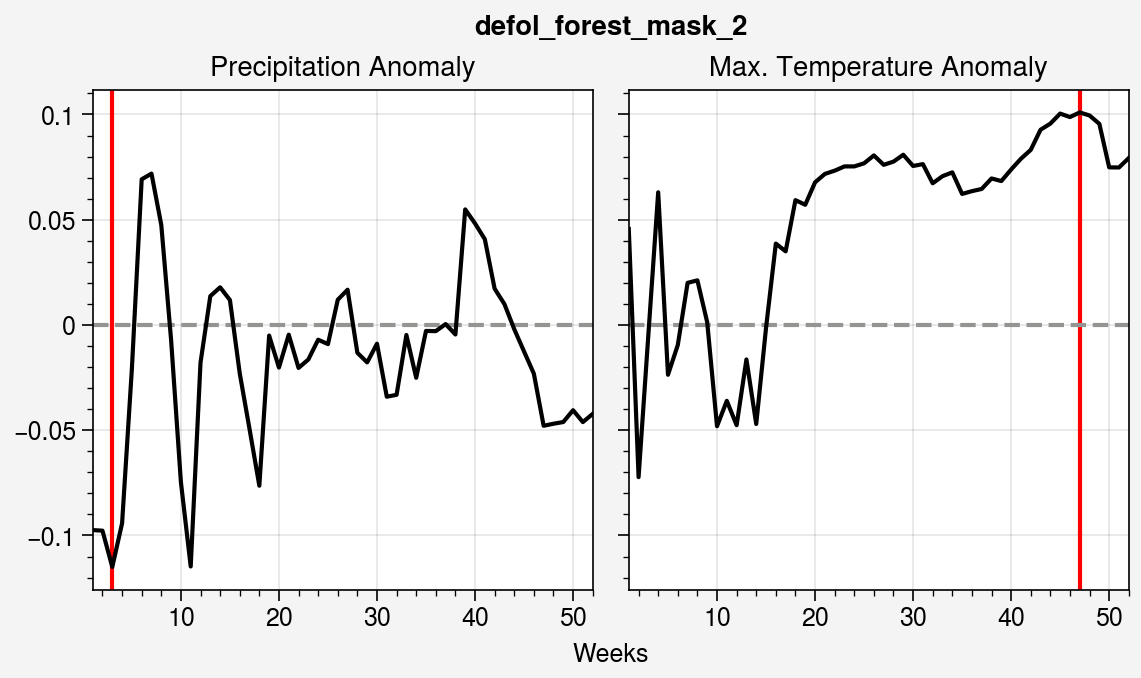

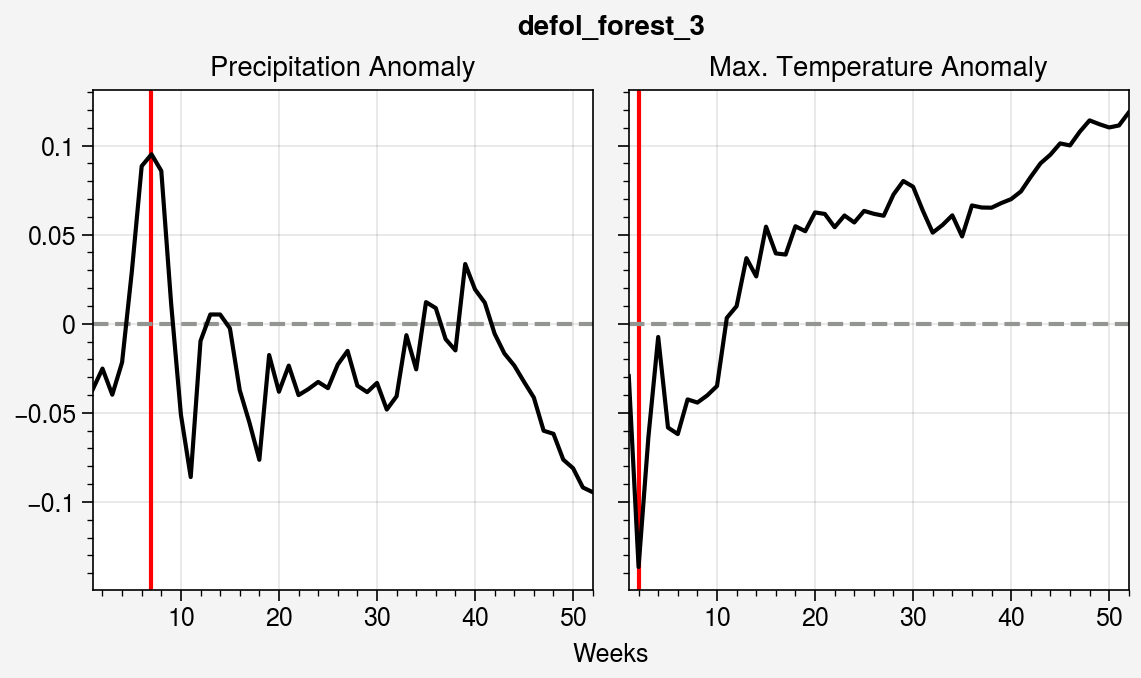

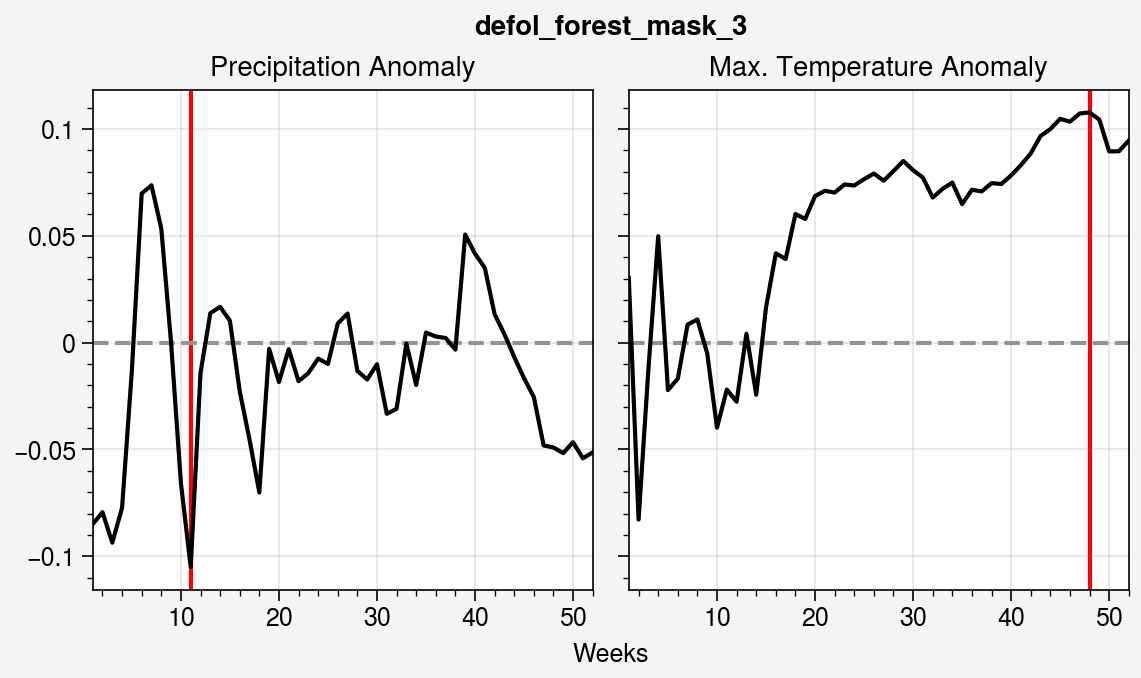

In [42]:
test_metrics_on_lag(full_df)

## Grid Cell masking
Certain grid cells may contain very little forest, as well as not having experienced any outbreak at all. This grid cells may exhibit patterns that strongly differ from that of pixels with ample forest that had experienced some defoliation. Here, we test the impacts that both of these choices have on correlation results. \
Forest masking has little impact on patterns, but correlation does appear to increase when only using heavily forested pixels. I will use 25,000,000 as a balance between maintaining enough pixels and getting highest agreement. \
Defoliation masking has significant impacts on patterns, thus it needs to be intensively considered. Generally, masking pixels with less defoliation decreases correlation (and in some cases may flip the direction of correlation). For the sake of maintaining robust statistical analyses, I think I will likely use little to no cutoff for defoliation.

In [48]:
def test_grid_cell_forest_masking(df, metric):
    for cutoff in [1_000_000,  5_000_000, 10_000_000, 25_000_000, 50_000_000]:
        # Filter out cells with insufficient forest area, and adjust defoliated area by forested area.
        df_cut = df[df['forest'] > cutoff].copy()
    
        make_lag_fig(df_cut, prcp_anom_cols, tmax_anom_cols, metric, cutoff)

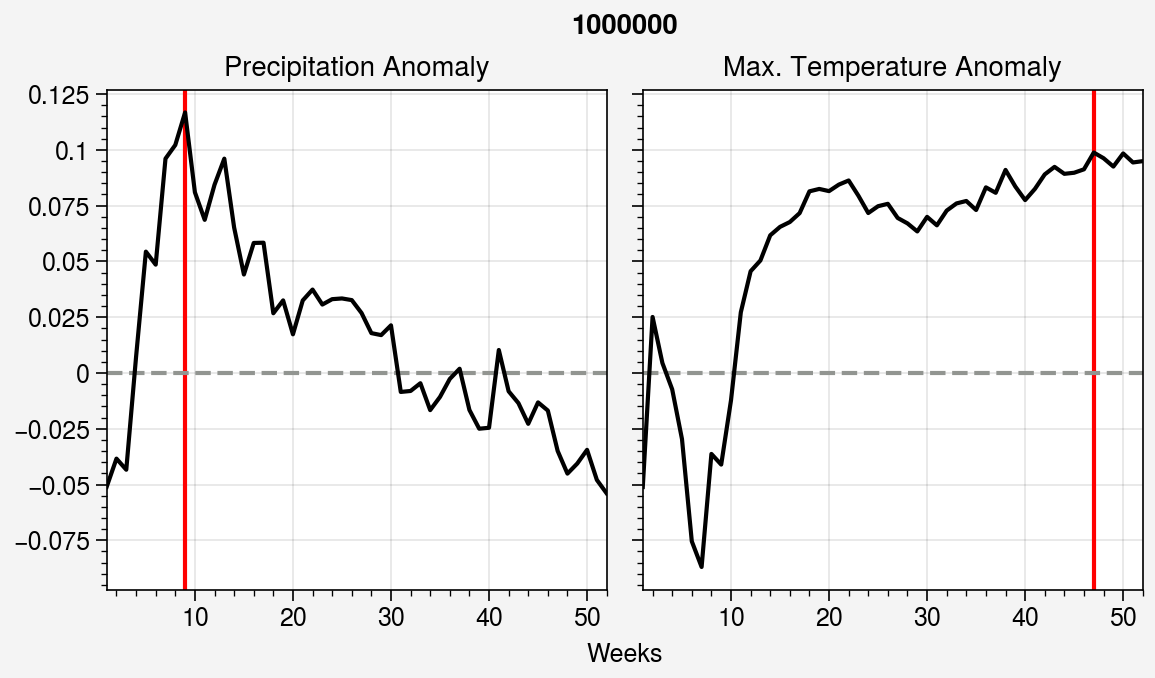

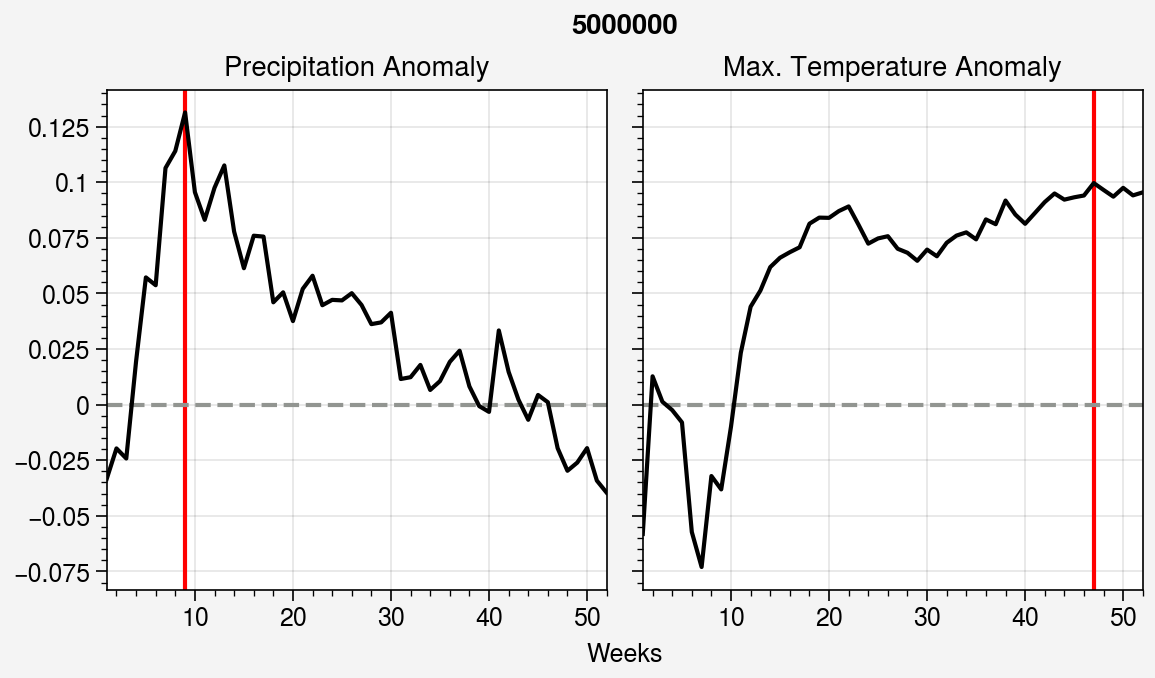

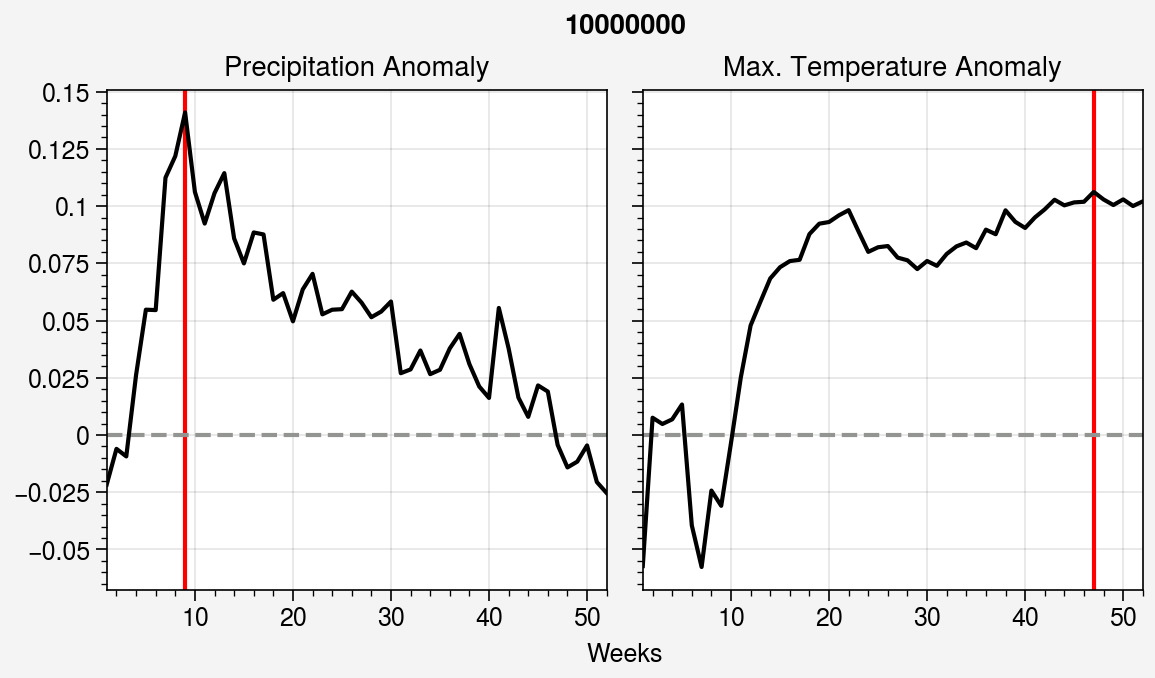

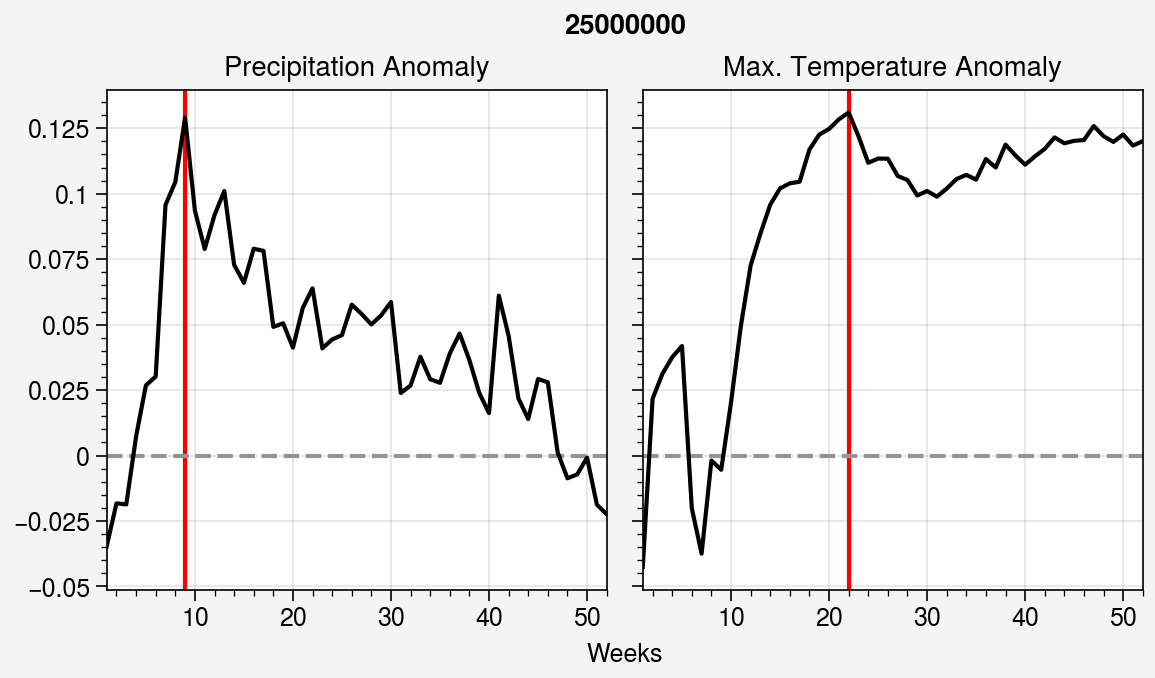

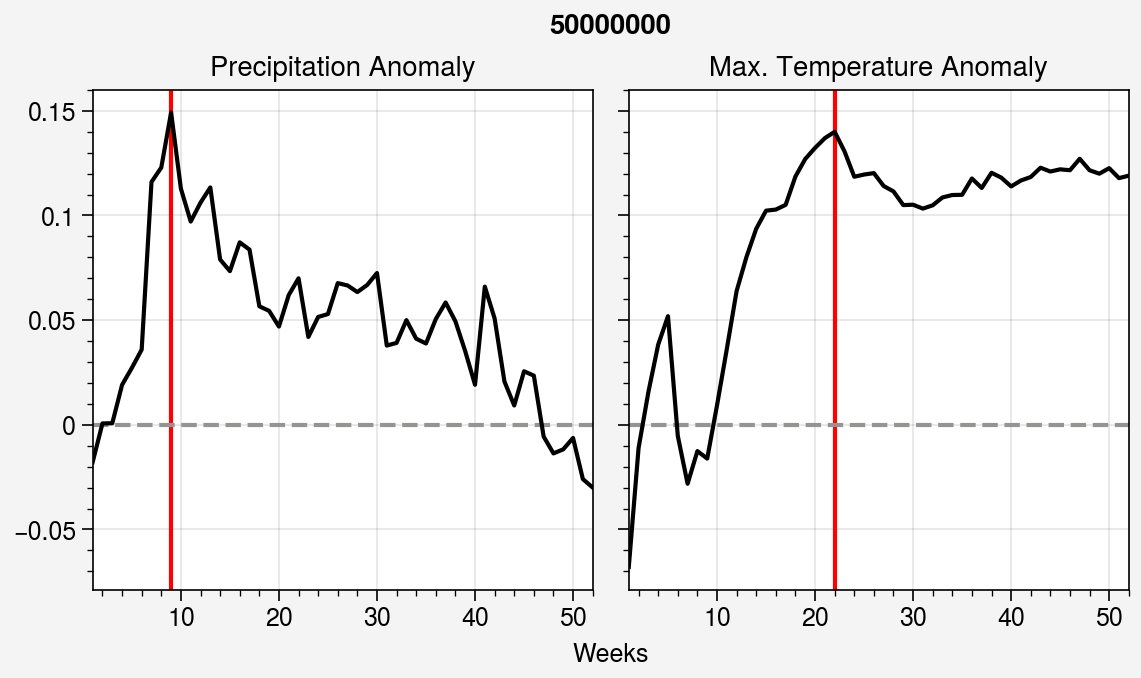

In [49]:
test_grid_cell_forest_masking(df_2021, 'defol_forest_3')

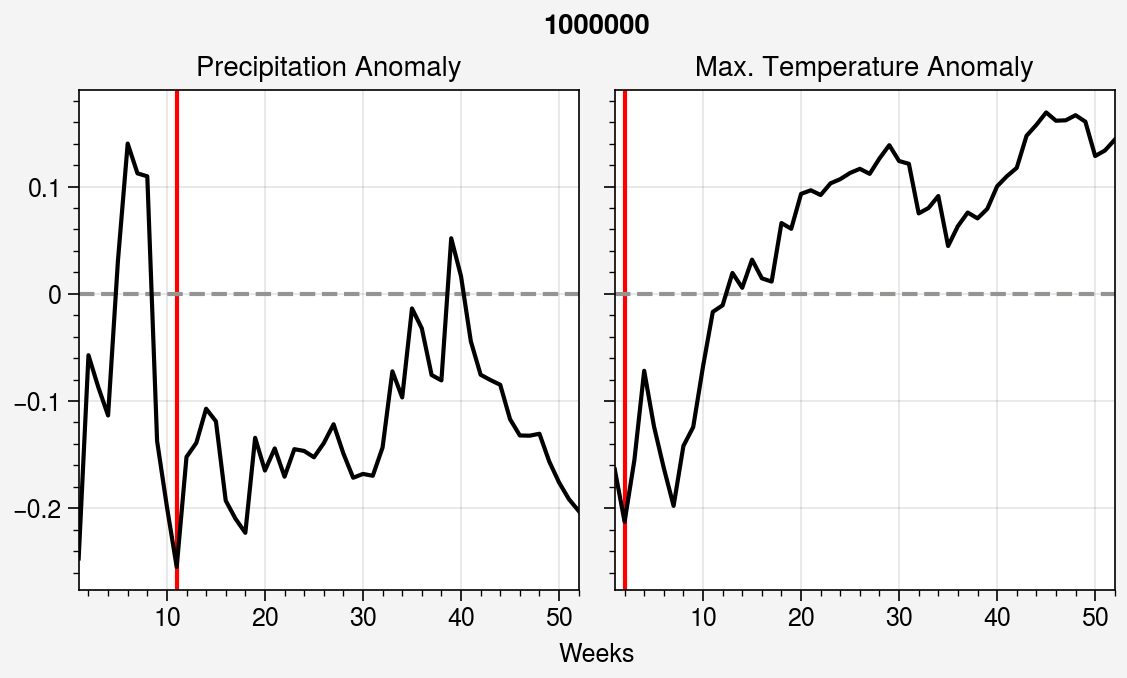

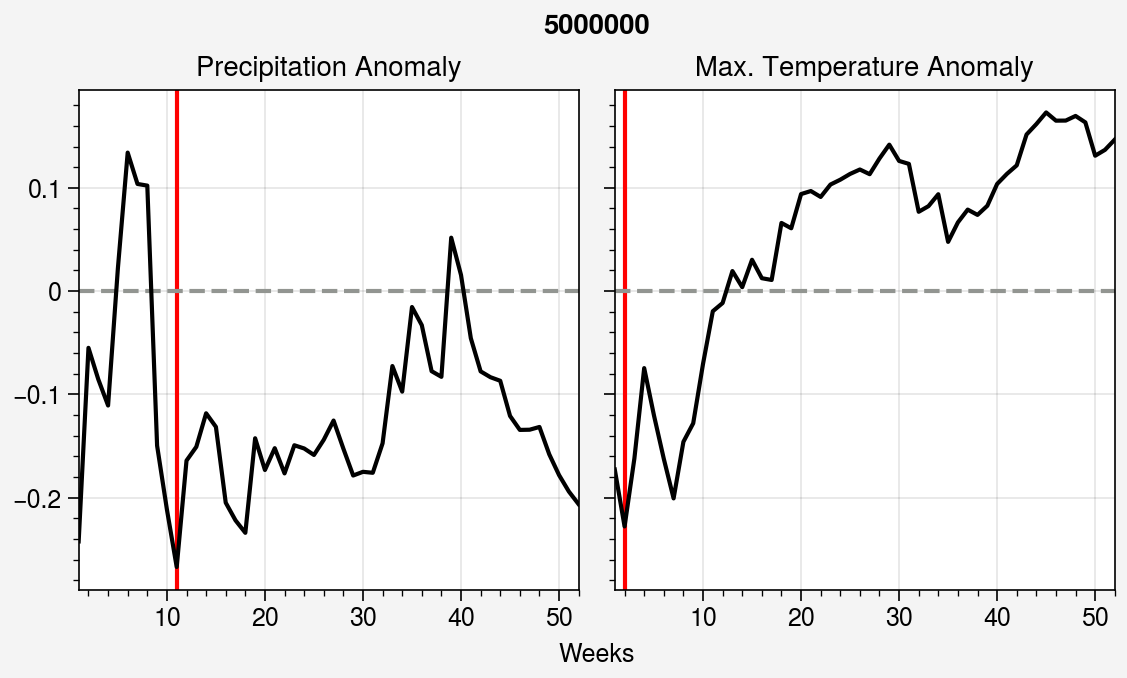

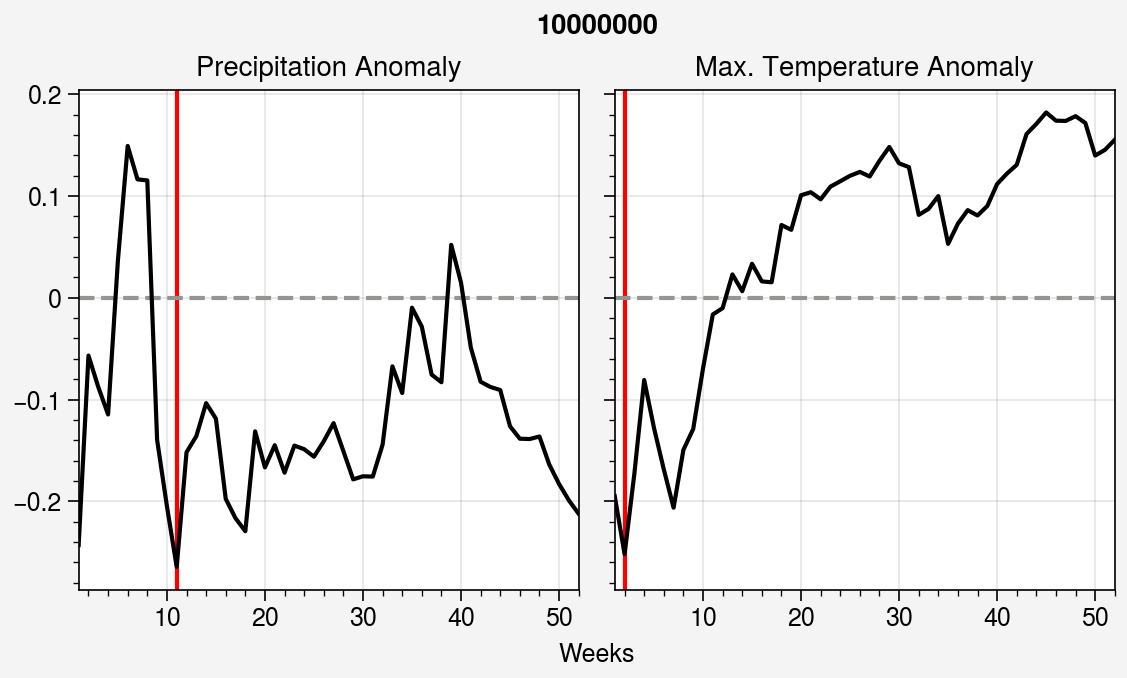

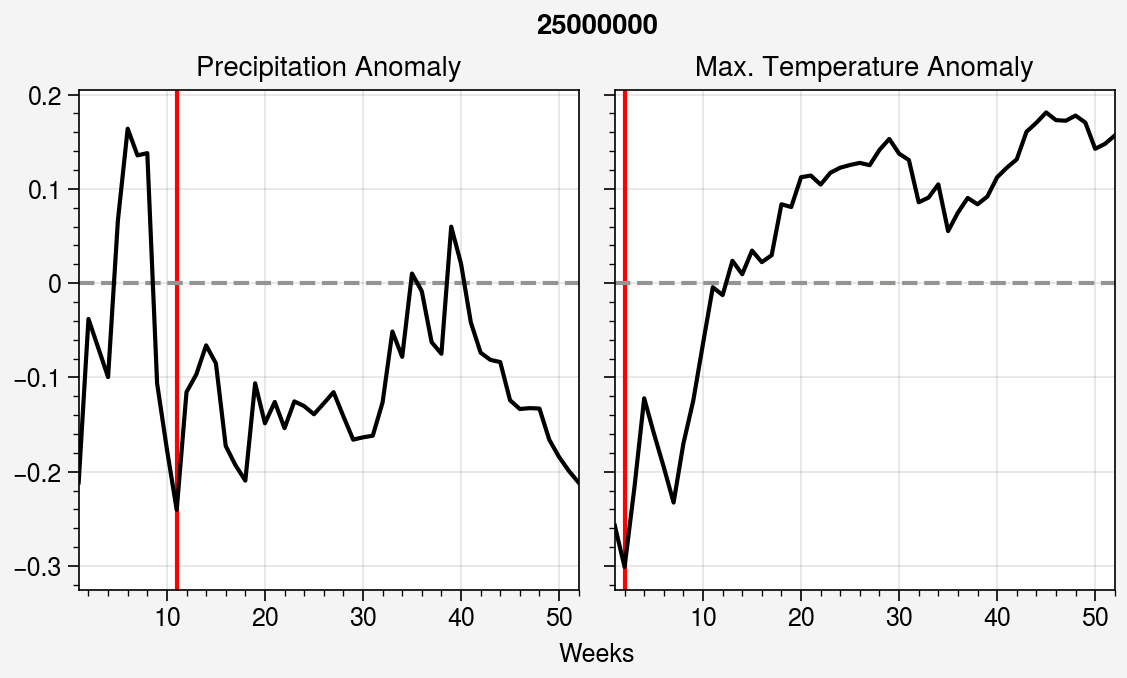

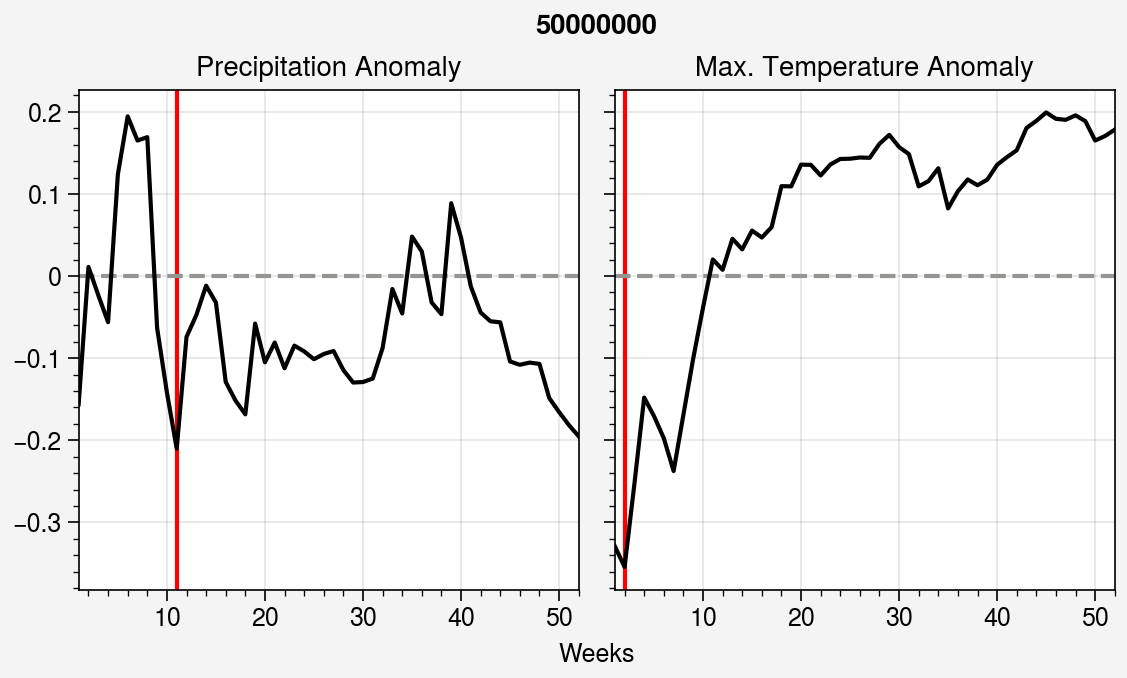

In [50]:
test_grid_cell_forest_masking(df_2023, 'defol_forest_3')

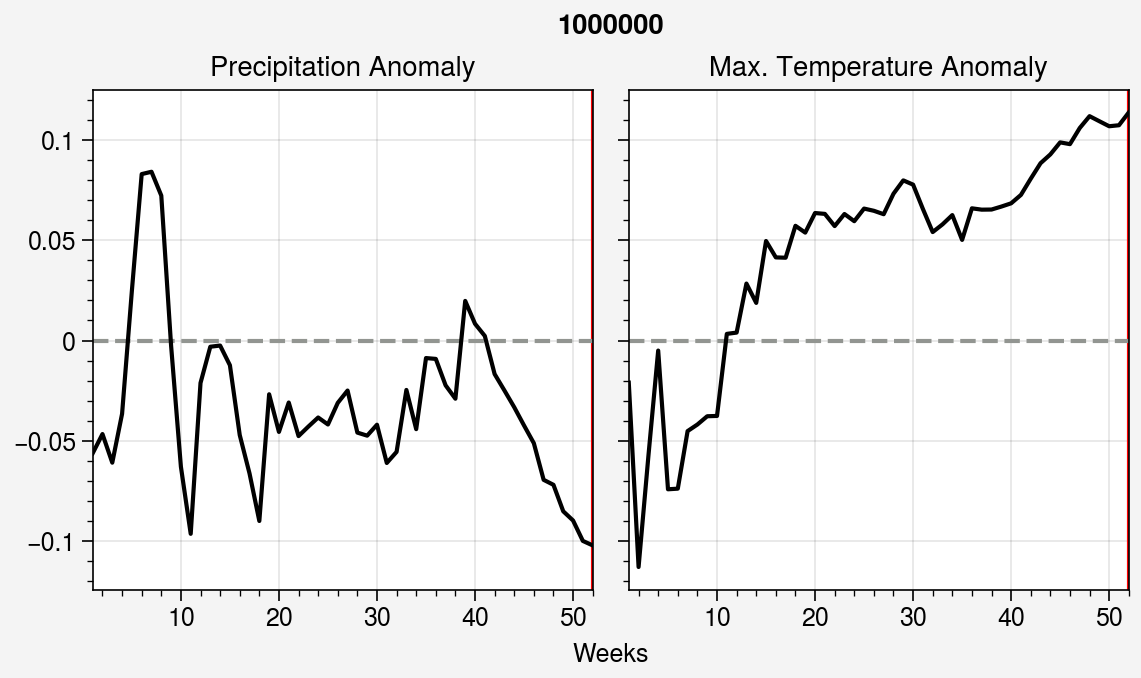

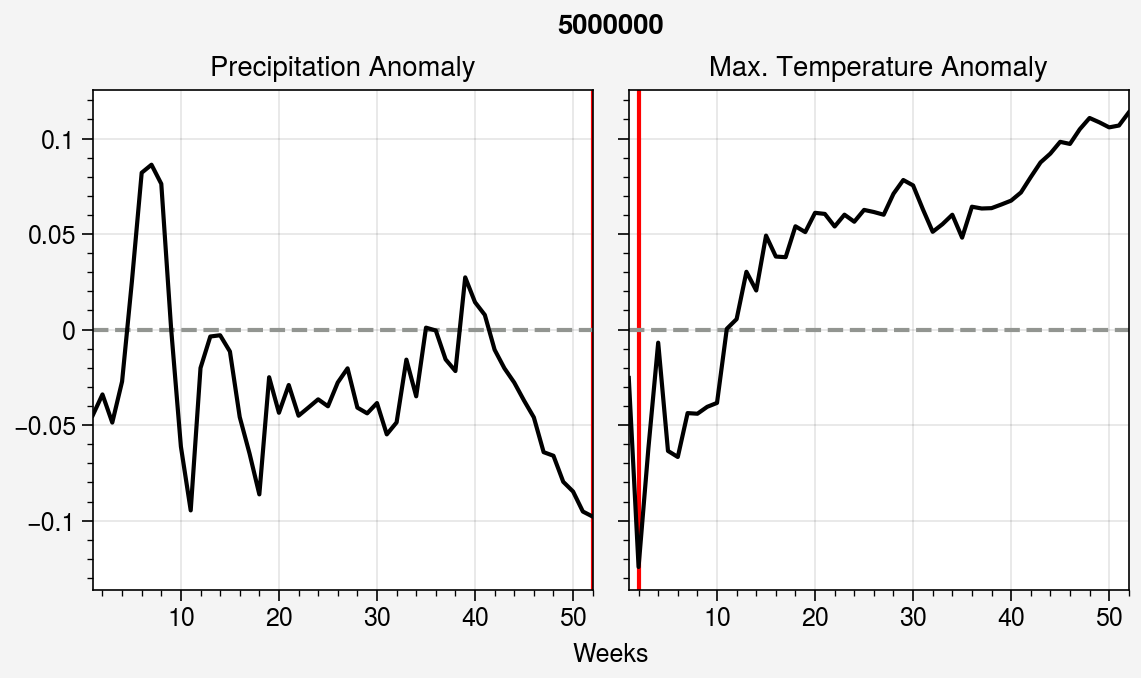

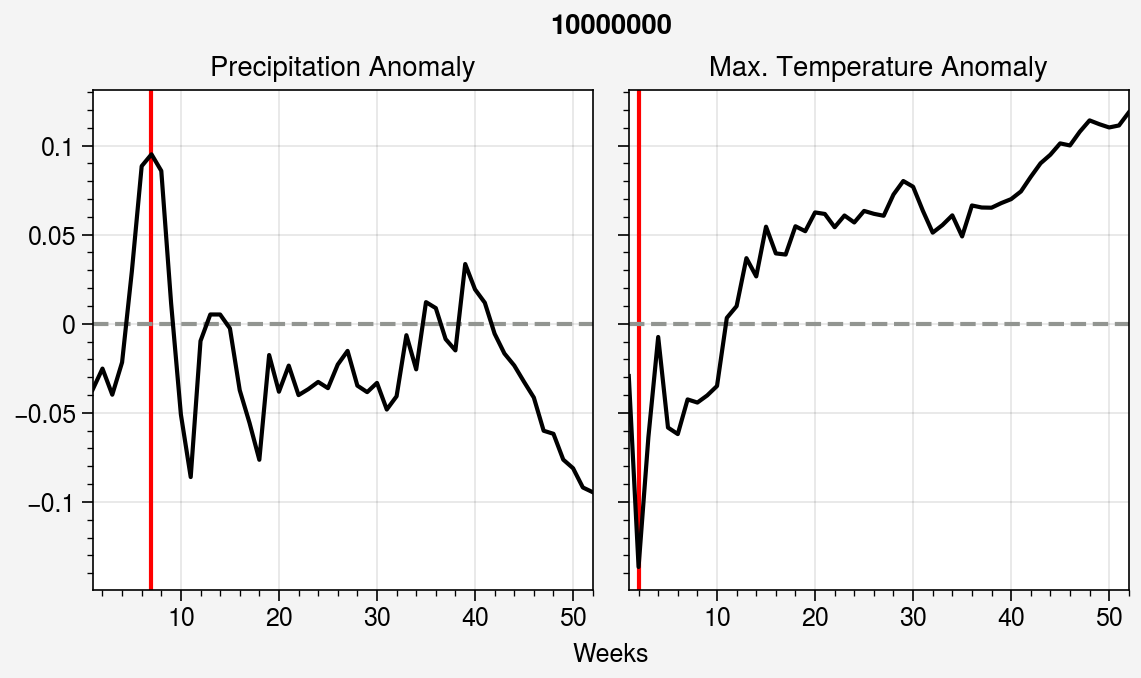

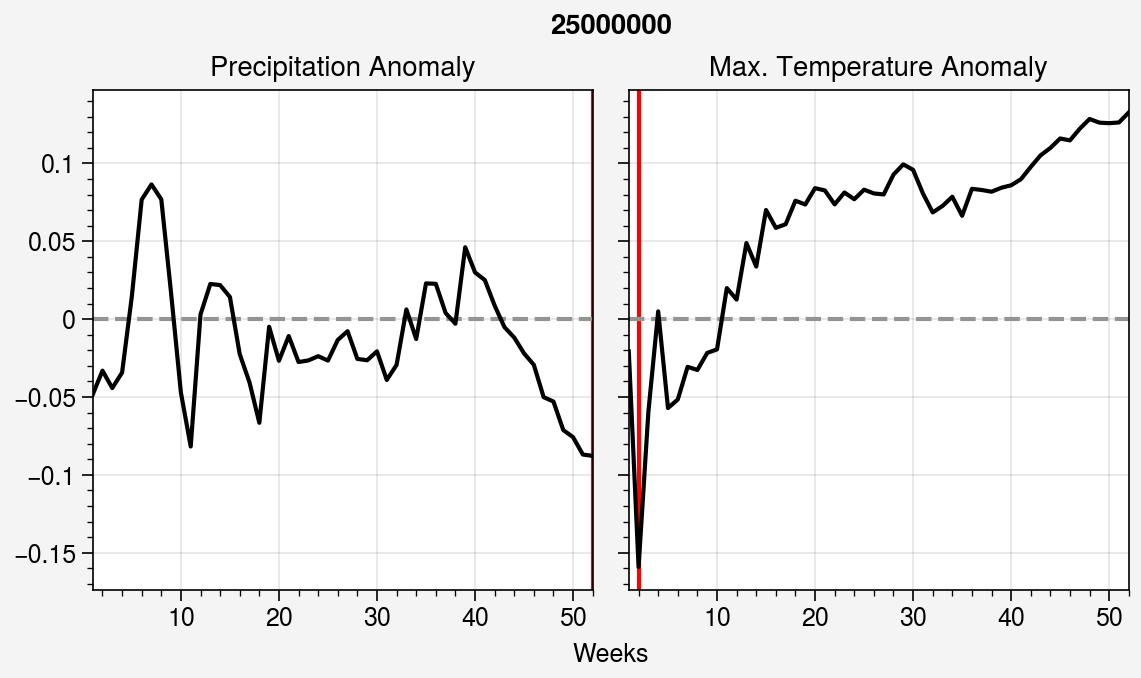

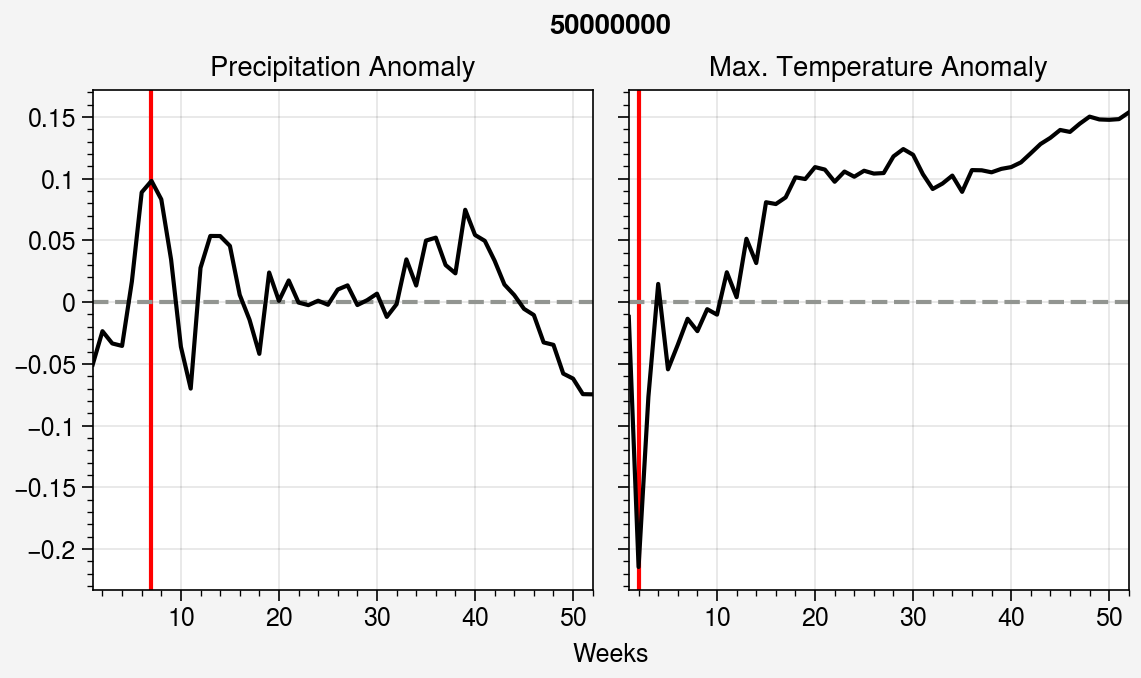

In [51]:
test_grid_cell_forest_masking(full_df, 'defol_forest_3')

In [159]:
def test_grid_cell_defol_masking(df, metric):
    for cutoff in [0, 0.005,  0.01, 0.025, 0.05]:
        df_cut = df[df['forest'] > 25_000_000]
        df_cut = df_cut[df_cut[metric] > cutoff].copy()
    
        make_lag_fig(df_cut, prcp_anom_cols, tmax_anom_cols, metric, cutoff)

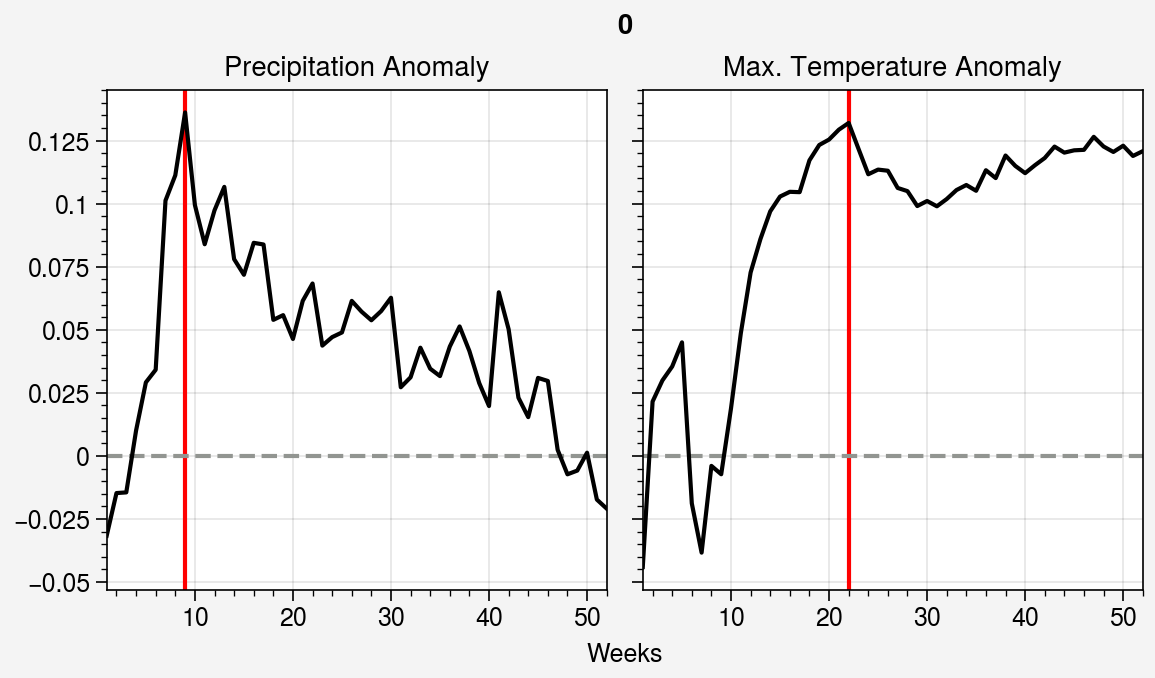

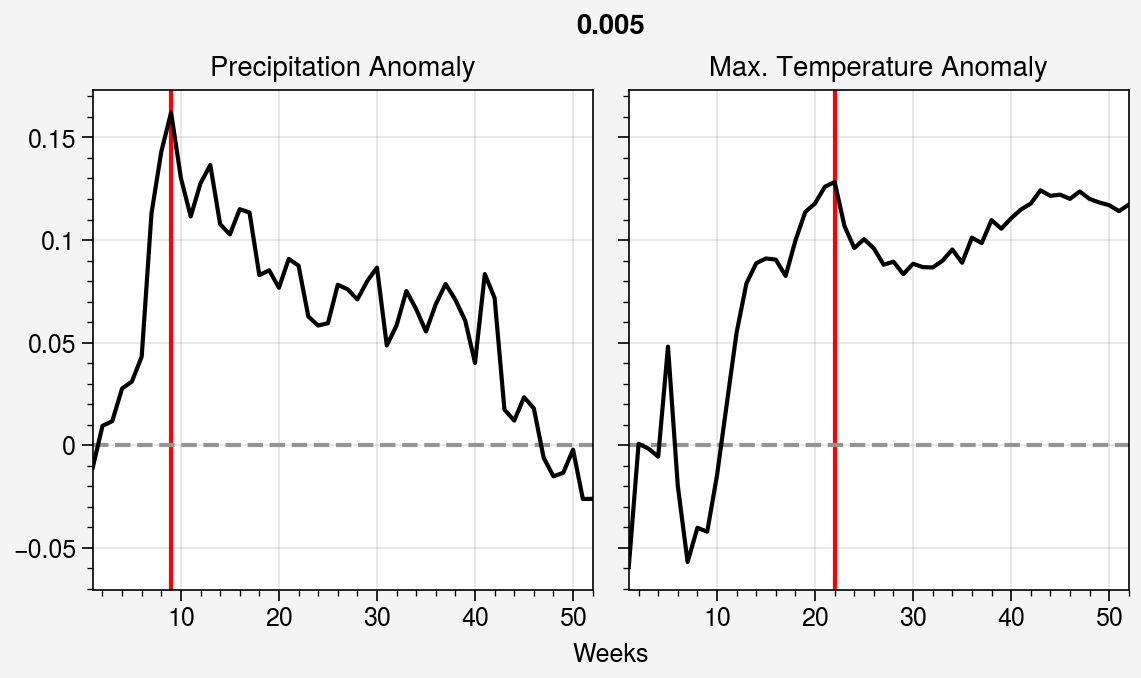

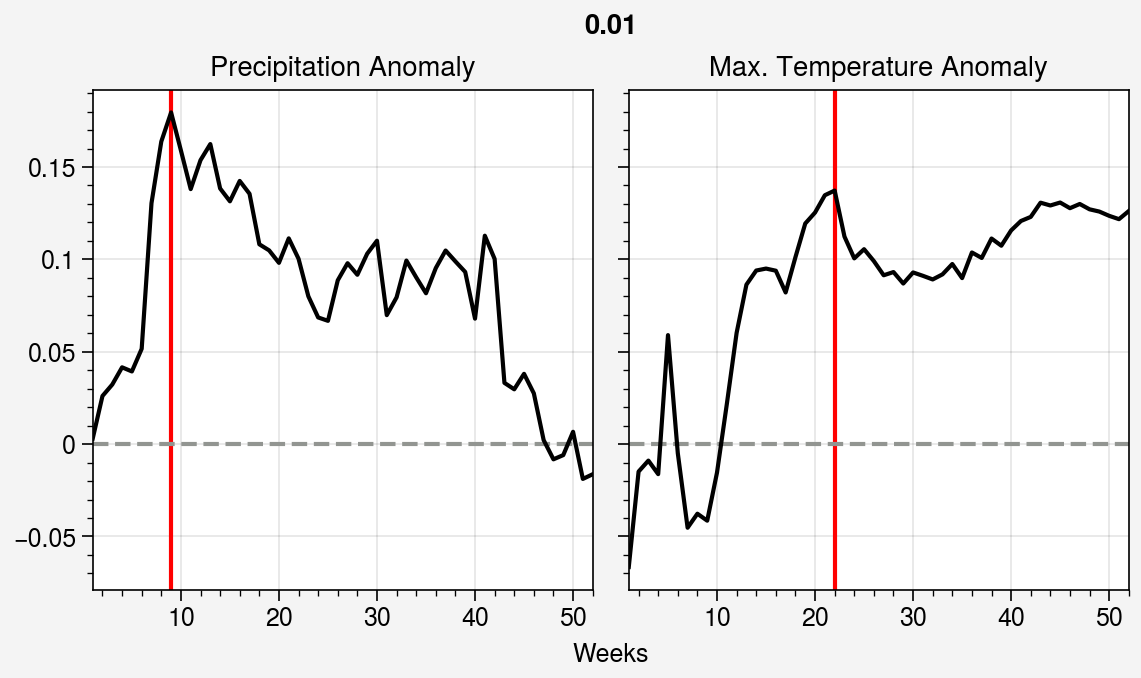

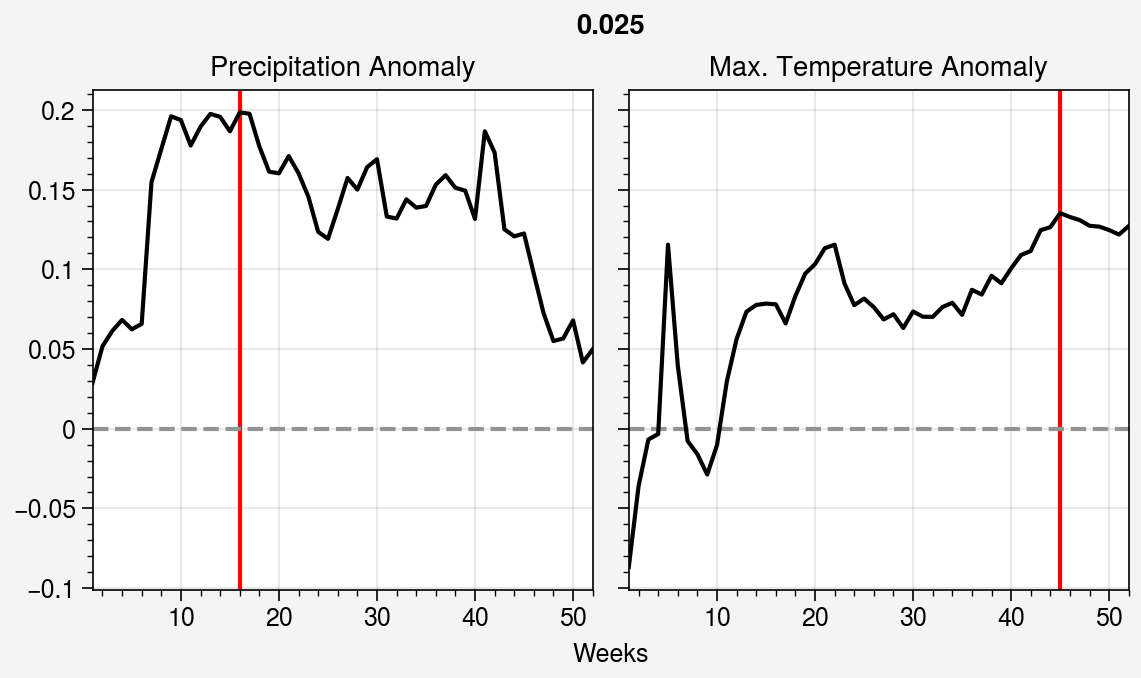

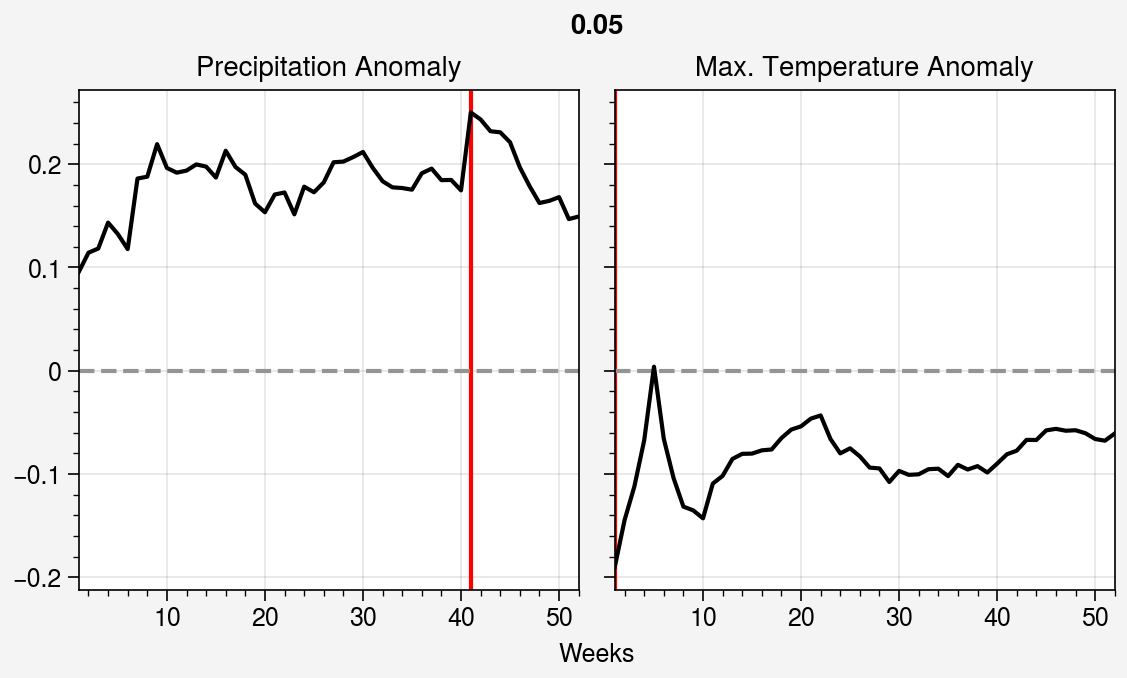

In [160]:
test_grid_cell_defol_masking(df_2021, 'defol_forest_3')

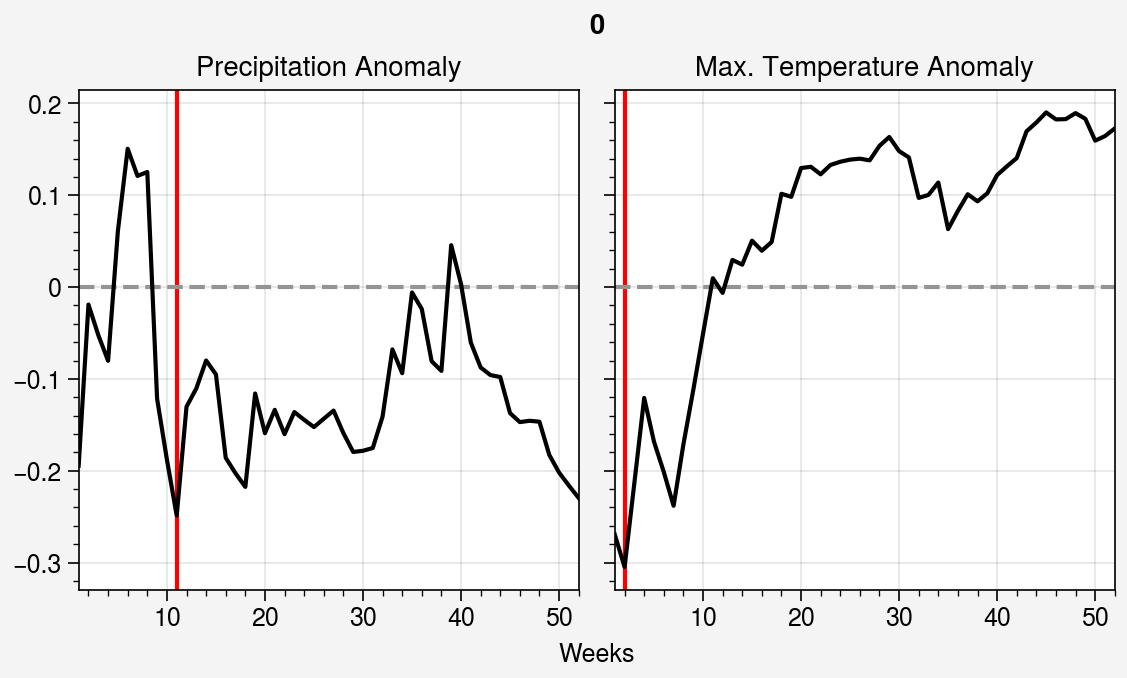

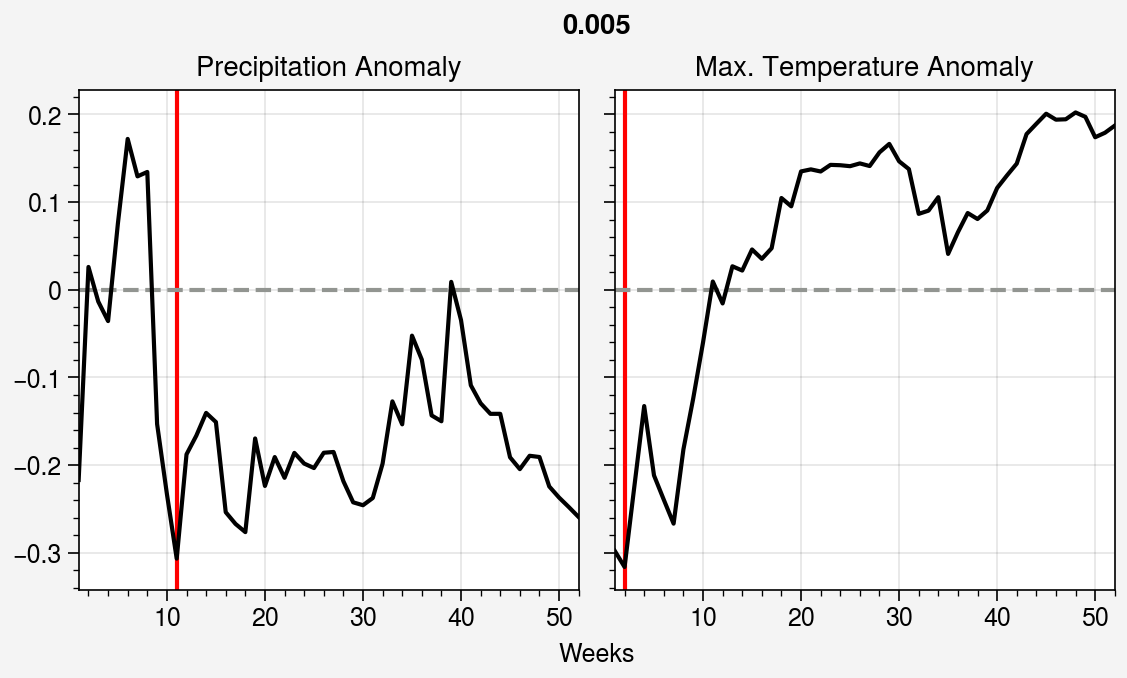

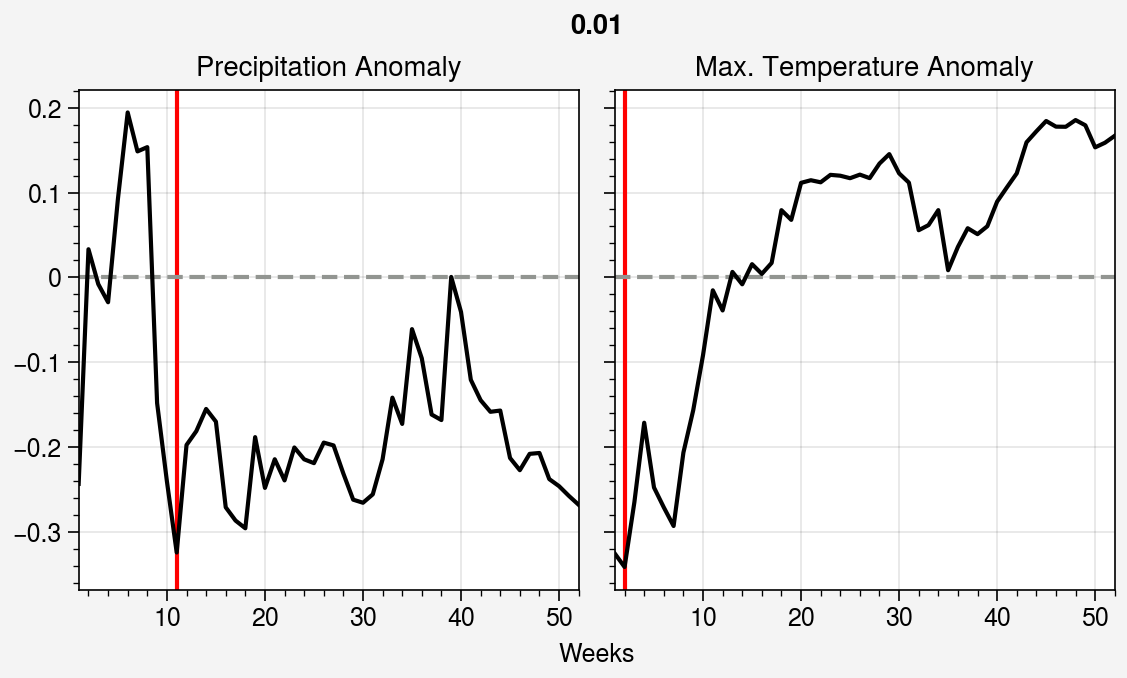

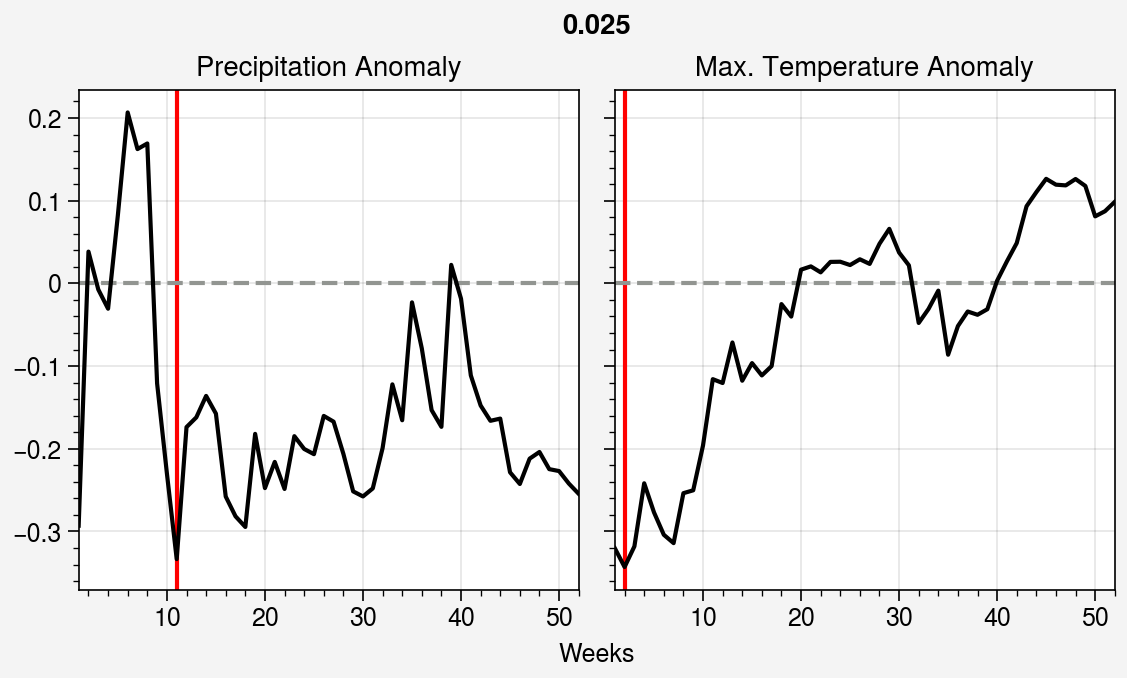

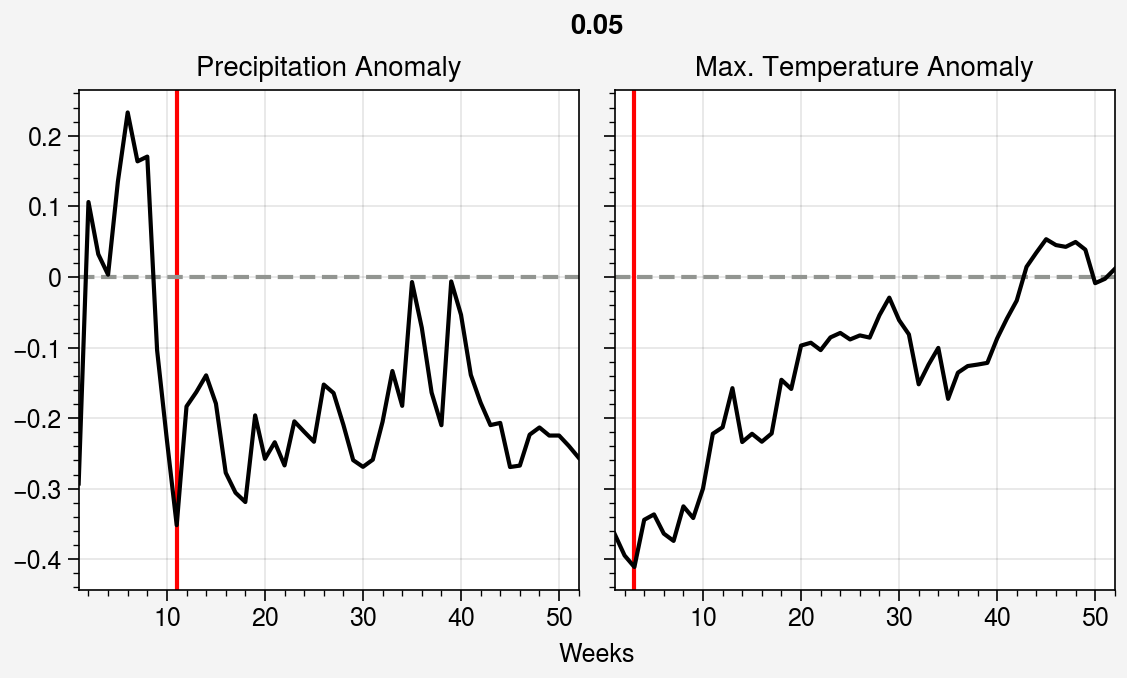

In [161]:
test_grid_cell_defol_masking(df_2023, 'defol_forest_3')

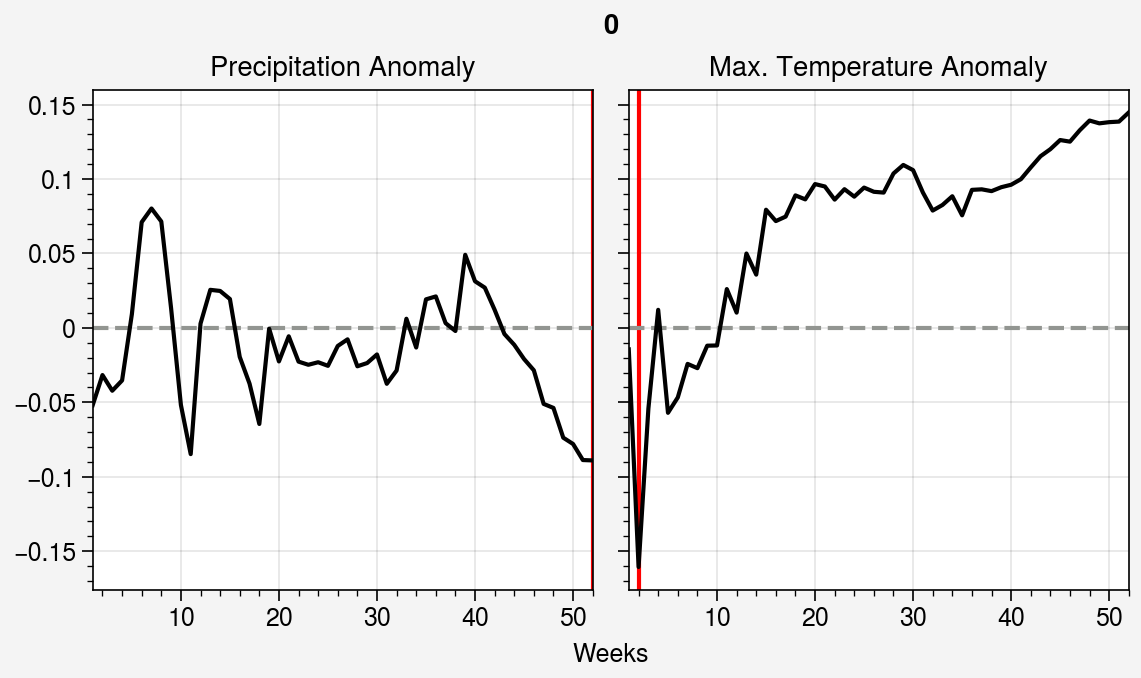

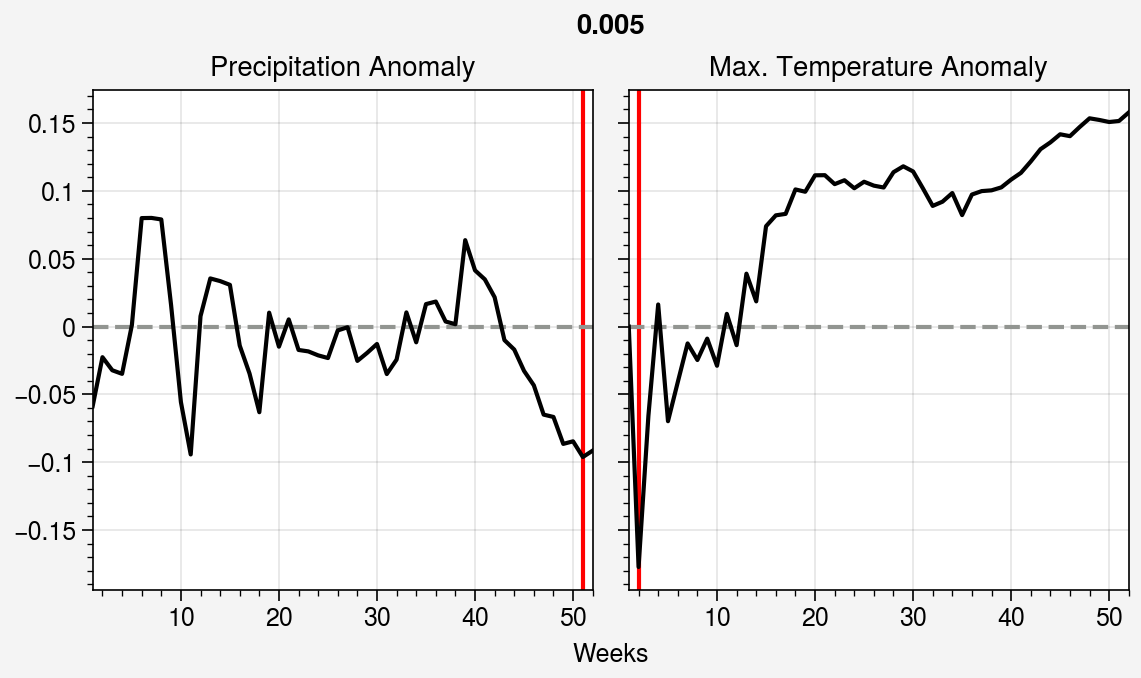

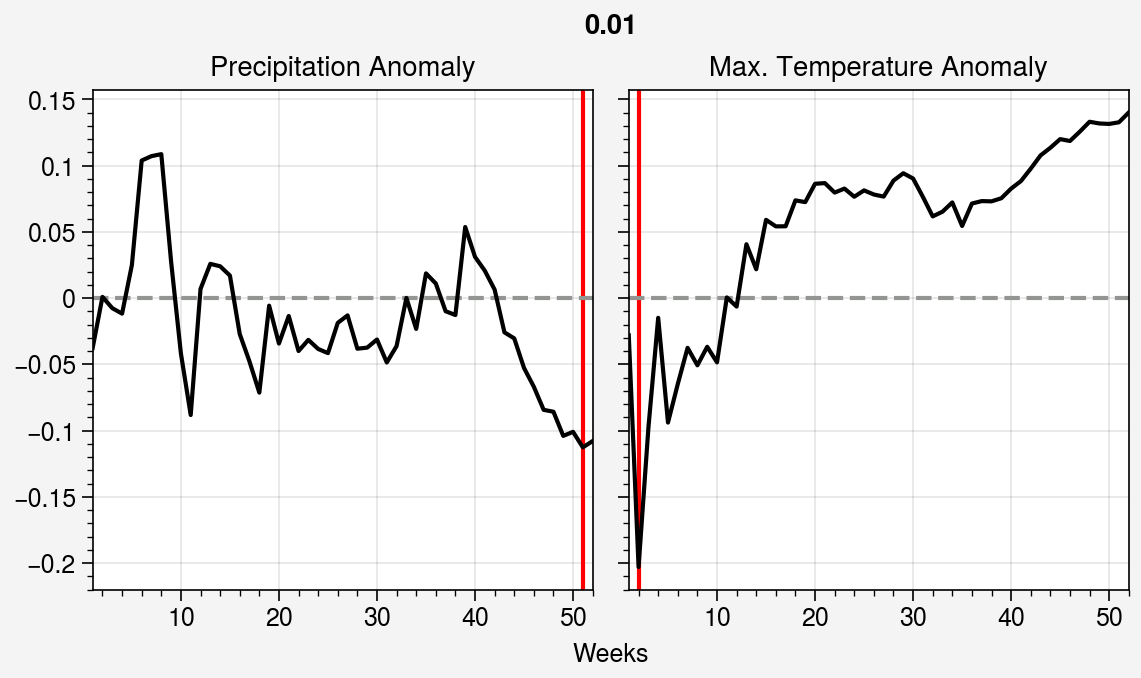

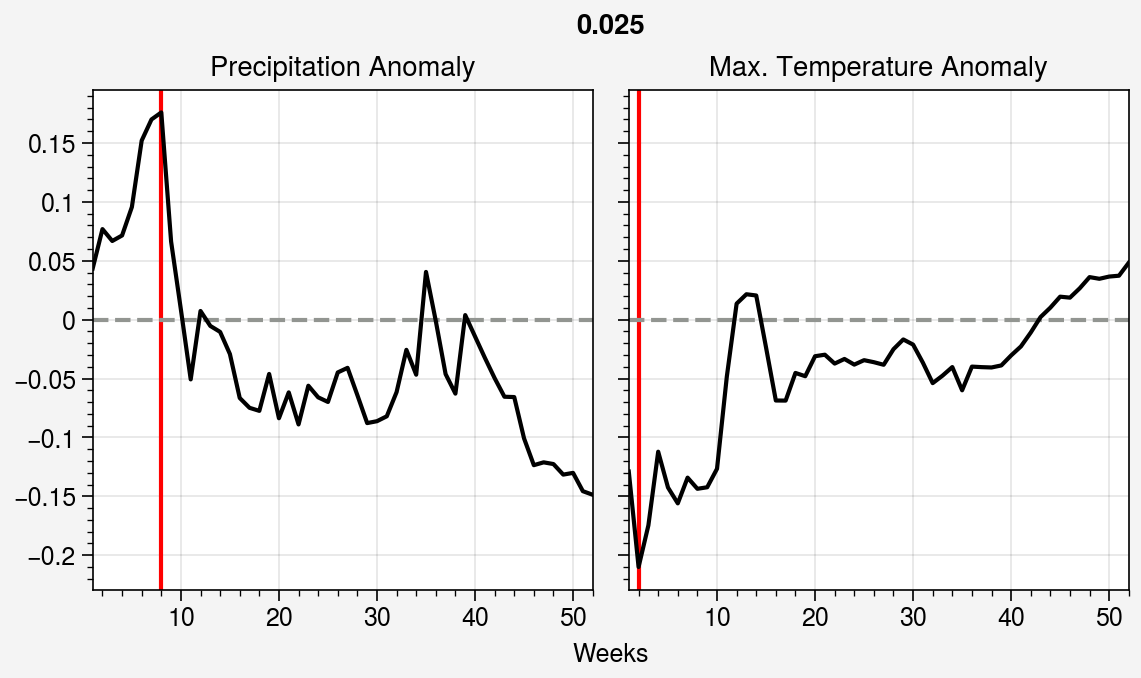

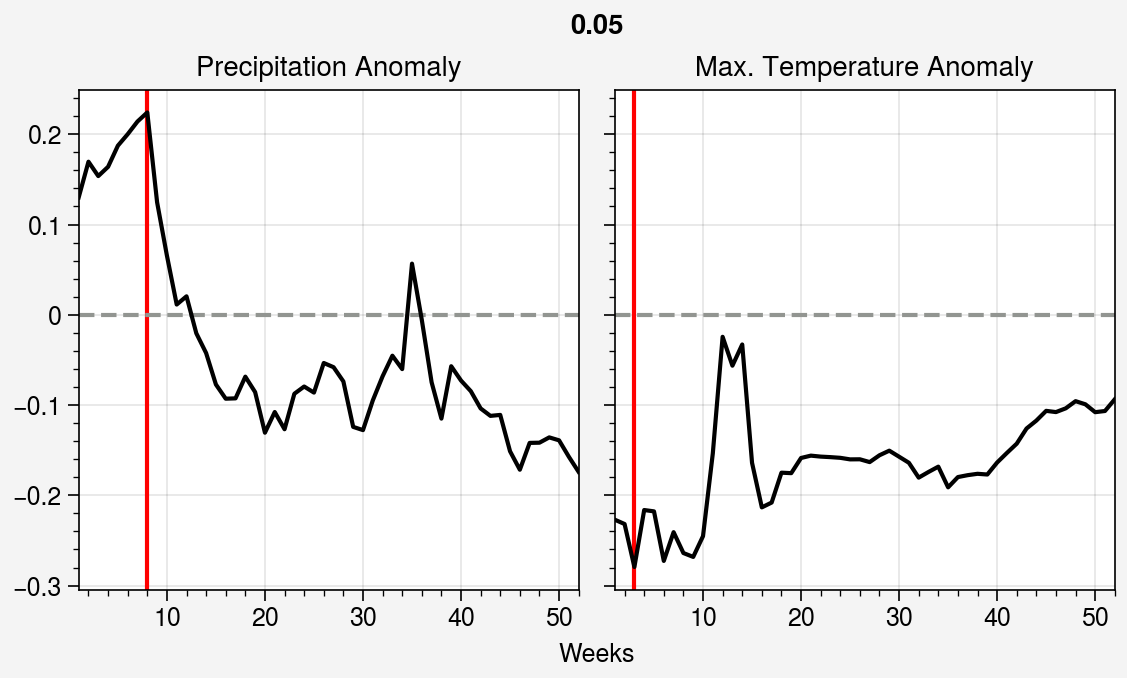

In [162]:
test_grid_cell_defol_masking(full_df, 'defol_forest_3')

## Controlling for mean effects
There is a possibility that there exists correlations between mean precipitation and anomaly (e.g. dry regions experiences worse droughts). To control for that, we test computing partial correlations controlling for mean precipitation and mean maximum temperature respectively. 

In [147]:
def pcor(X: pd.DataFrame):
    X = X.select_dtypes(['number'])
    X = (X - X.mean()) / X.std()
    precision = np.linalg.inv(X.cov())
    diag = np.diag(precision)
    Z = np.sqrt(np.outer(diag, diag))
    partial = -precision / Z
    np.fill_diagonal(partial, 1)
    return partial

In [172]:
def make_lag_fig2(df, prcp_anom_cols, prcp_mean_cols, tmax_anom_cols, tmax_mean_cols, metric, title):
    fig, axes = uplt.subplots(ncols=2, suptitle=title)
        
    corrs = []
    for prcp_anom_col, prcp_mean_col in zip(prcp_anom_cols, prcp_mean_cols):
        corrs.append(pcor(df[[metric, prcp_anom_col, prcp_mean_col]])[0, 1])
    corrs = np.array(corrs)
    
    i = np.argmax(np.abs(corrs))+1
    
    axes[0].axvline(i, color='red')
    axes[0].text(i+1, 0.9, i, transform=axes[0].get_xaxis_transform(), fontsize=12)
    axes[0].axhline(0, color='gray', linestyle='dashed')
    axes[0].plot(np.arange(1, corrs.shape[0]+1), corrs, color='black')
    axes[0].format(title='Precipitation Anomaly', xlabel='Weeks')
    
    corrs = []
    for tmax_anom_col, tmax_mean_col in zip(tmax_anom_cols, tmax_mean_cols):
        corrs.append(pcor(df[[metric, tmax_anom_col, tmax_mean_col]])[0, 1])
    corrs = np.array(corrs)
    
    i = np.argmax(np.abs(corrs))+1
    
    axes[1].axvline(i, color='red')
    axes[1].text(i+1, 0.9, i, transform=axes[1].get_xaxis_transform(), fontsize=12)
    axes[1].axhline(0, color='gray', linestyle='dashed')
    axes[1].plot(np.arange(1, corrs.shape[0]+1), corrs, color='black')
    axes[1].format(title='Max. Temperature Anomaly', xlabel='Weeks')

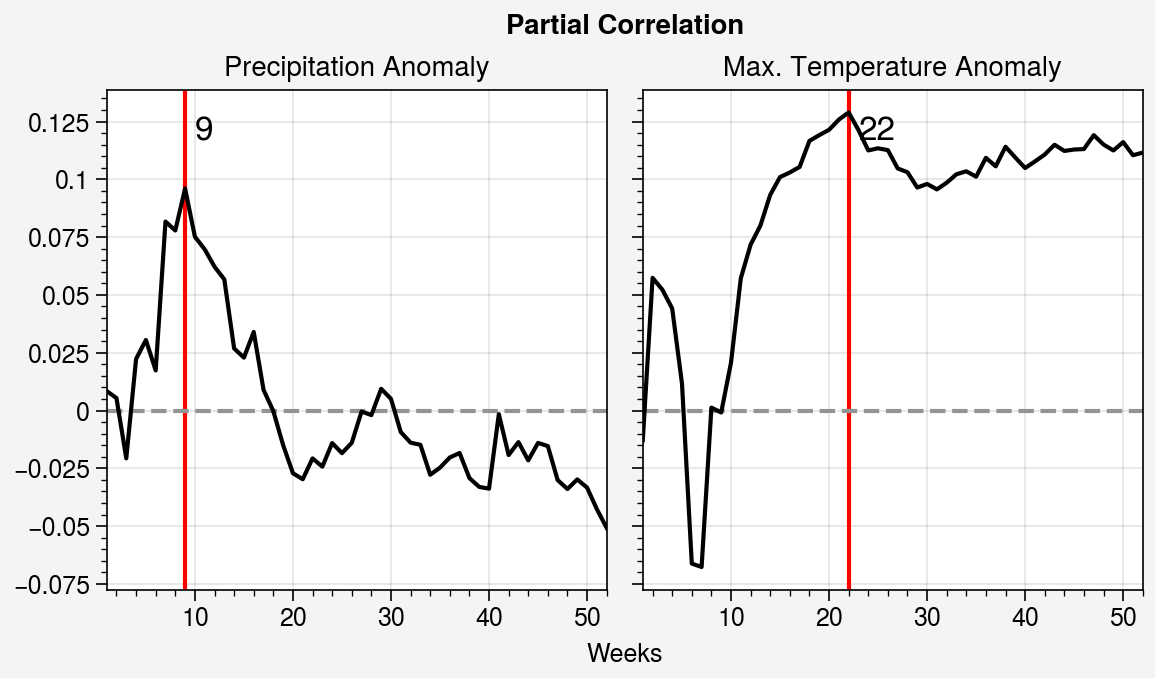

In [182]:
masked_df_2021 = df_2021[df_2021['forest'] > 25_000_000].copy()
make_lag_fig2(masked_df_2021, prcp_anom_cols, prcp_mean_cols, tmax_anom_cols, tmax_mean_cols, 'defol_forest_3', 'Partial Correlation')

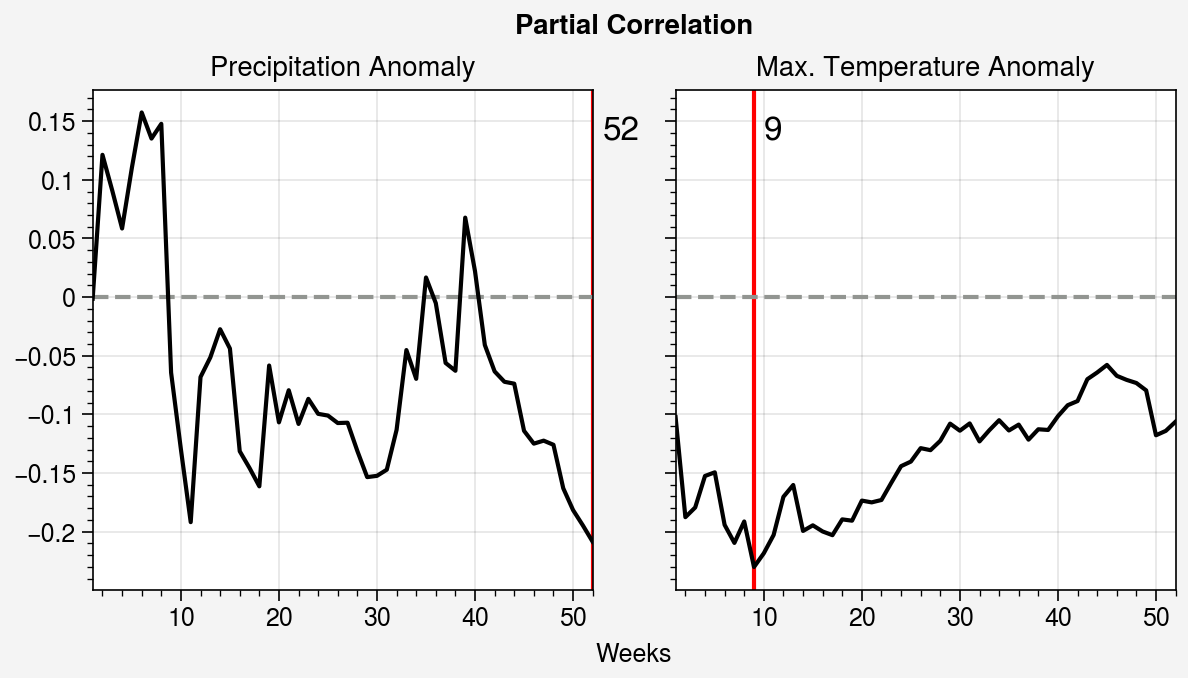

In [183]:
masked_df_2023 = df_2023[df_2023['forest'] > 25_000_000].copy()
make_lag_fig2(masked_df_2023, prcp_anom_cols, prcp_mean_cols, tmax_anom_cols, tmax_mean_cols, 'defol_forest_3', 'Partial Correlation')

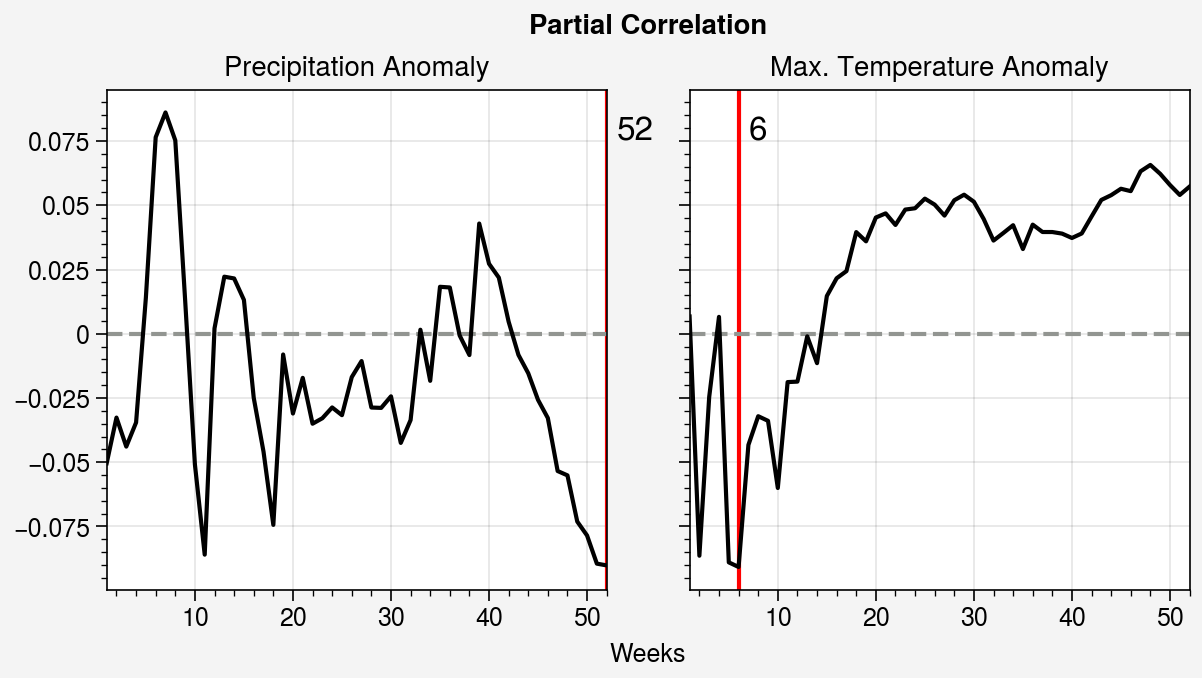

In [184]:
masked_full_df = full_df[full_df['forest'] > 25_000_000].copy()
make_lag_fig2(masked_full_df, prcp_anom_cols, prcp_mean_cols, tmax_anom_cols, tmax_mean_cols, 'defol_forest_3', 'Partial Correlation')

In [190]:
masked_df_2021['frac_deciduous'] = masked_df_2021['deciduous'] / masked_df_2021['forest']
predictors = masked_df_2021[['frac_deciduous', 'prcp_anom_9', 'prcp_mean_9', 'tmax_anom_22', 'tmax_mean_22']].copy()
predictors = (predictors - predictors.mean()) / predictors.std()
predictors['defol_forest_2'] = masked_df_2021['defol_forest_2']

mod_2021 = sm.ols(formula='defol_forest_2 ~ prcp_anom_9 + prcp_mean_9 + tmax_anom_22 + tmax_mean_22 + frac_deciduous', data=predictors)

res_2021 = mod_2021.fit()

print(res_2021.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_2   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     11.04
Date:                Wed, 14 May 2025   Prob (F-statistic):           2.24e-10
Time:                        13:12:33   Log-Likelihood:                 1590.2
No. Observations:                1057   AIC:                            -3168.
Df Residuals:                    1051   BIC:                            -3139.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0315      0.002     18.

In [193]:
res_2021.pvalues.values

array([2.08225105e-69, 2.18846923e-05, 4.39846602e-01, 1.66168810e-03,
       2.07022114e-02, 8.15028930e-03])

In [191]:
masked_df_2023['frac_deciduous'] = masked_df_2023['deciduous'] / masked_df_2023['forest']
predictors = masked_df_2023[['frac_deciduous', 'prcp_anom_9', 'prcp_mean_9', 'tmax_anom_22', 'tmax_mean_22']].copy()
predictors = (predictors - predictors.mean()) / predictors.std()
predictors['defol_forest_2'] = masked_df_2023['defol_forest_2']

mod_2023 = sm.ols(formula='defol_forest_2 ~ prcp_anom_9 + prcp_mean_9 + tmax_anom_22 + tmax_mean_22 + frac_deciduous', data=predictors)

res_2023 = mod_2023.fit()

print(res_2023.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_2   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     34.79
Date:                Wed, 14 May 2025   Prob (F-statistic):           5.56e-33
Time:                        13:12:50   Log-Likelihood:                 1684.5
No. Observations:                1057   AIC:                            -3357.
Df Residuals:                    1051   BIC:                            -3327.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0366      0.002     24.

In [198]:
pvalues = np.hstack([res_2021.pvalues.values, res_2023.pvalues.values])
fdrcorrection(pvalues, alpha=0.10, method='indep', is_sorted=False)

(array([ True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True]),
 array([1.24935063e-068, 5.25232615e-005, 4.79832657e-001, 2.84860817e-003,
        2.76029486e-002, 1.22254339e-002, 7.52259767e-102, 8.53545950e-001,
        8.69513677e-007, 3.75456731e-004, 4.19408676e-024, 4.33163045e-002]))

In [187]:
masked_full_df['frac_deciduous'] = masked_full_df['deciduous'] / masked_full_df['forest']
predictors = masked_full_df[['frac_deciduous', 'prcp_anom_9', 'prcp_mean_9', 'tmax_anom_22', 'tmax_mean_22']].copy()
predictors = (predictors - predictors.mean()) / predictors.std()
predictors['defol_forest_2'] = masked_full_df['defol_forest_2']

mod = sm.ols(formula='defol_forest_2 ~ prcp_anom_9 + prcp_mean_9 + tmax_anom_22 + tmax_mean_22 + frac_deciduous', data=predictors)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         defol_forest_2   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     12.15
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.25e-11
Time:                        13:07:32   Log-Likelihood:                 3193.6
No. Observations:                2114   AIC:                            -6375.
Df Residuals:                    2108   BIC:                            -6341.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0341      0.001     29.

<a list of 1 Line2D objects>

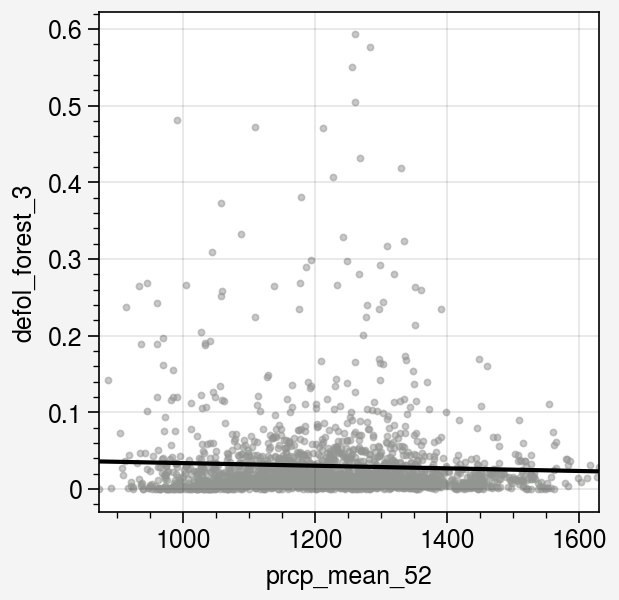

In [63]:
test_df = full_df[full_df['defol_forest_3'] > 0].copy()

df = test_df[test_df['forest'] > 25_000_000].copy()
fig, ax = uplt.subplots()
ax.scatter(df['prcp_mean_52'], df['defol_forest_3'], ms=5, alpha=0.5, color='gray')

z = np.polyfit(df['prcp_mean_52'], df['defol_forest_3'], 1)
p = np.poly1d(z)
bounds = np.array([df['prcp_mean_52'].min(), df['prcp_mean_52'].max()])
ax.plot(bounds, p(bounds), color='black')